# Binary Simplification in Metabolomics

Notebook to support the study on the application of **Bin**ary **Sim**plification as a competing form of pre-processing procedure for high-resolution metabolomics data.

This is notebook `paper_binsim.ipynb`


## Organization of the Notebook

- Set up database of data sets
- Application of different pre-treatments (including BinSim) to each data set
- Random Forest - optimization, predictive accuracy and important features: comparison after aplication of different pre-processing procedures
- PLS-DA - optimization, predictive accuracy and important features: comparison after aplication of different pre-processing procedures

#### Needed Imports

In [1]:
import itertools

import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse

In [2]:
%matplotlib inline

## Description of dataset records

`datasets` is the global dict that holds all data sets. It is a **dict of dict's**

Each data set is **represented as a dict**.

TO CONSIDER: migrate the table of datasets to a pandas DataFrame.

Each record has the following fields (keys):

- `name`: the table/figure name of the data set
- `source`: the biological source for each dataset
- `mode`: the aquisition mode
- `alignment`: the alignment used to generate the data matrix
- `data`: the data matrix
- `target`: the sample labels, possibly already integer encoded
- `<treatment name>`: transformed data matrix. These treatment names can be
    - `original`: an alias to `data`
    - `imputed`: missing value imputed data, only
    - `P`: Pareto scaled data
    - `NP`: Pareto scaled and normalized
    - `NGP`: normalized, glog transformed and Pareto scaled
    - `BinSim`: binary simplified data

The keys of `datasets` may be shared with dicts holding records resulting from comparison analysis.

Here are the keys used in this study:

- GD_neg_global2
- GD_pos_global2
- GD_neg_class2
- GD_pos_class2
- YD
- YD2
- vitis_types


#### correspondence to previously used names/variables in more focused notebooks

`aligned_all_pos` ↔ `datasets[GD_pos_global2]`

`aligned_all_neg` ↔ `datasets[GD_neg_global2]`

`aligned_all_pos2` ↔ `datasets[GD_pos_class2]`

`aligned_all_neg2` ↔ `datasets[GD_neg_class2]`

## Description of grapevine data sets

Grapevine Datasets (Negative and Positive) - 33 samples belonging to 11 different grapevine varieties (3 samples per variety/biological group).

5 different _Vitis_ species (other than _V. vinifera_) varieties:

- CAN - 3 Samples (14, 15, 16) of _V. candicans Engelmann_ (VIVC variety number: 13508)
- RIP - 3 Samples (17, 18, 19) of _V. riparia Michaux_ (Riparia Gloire de Montpellier, VIVC variety number: 4824) 
- ROT - 3 Samples (20, 21, 22) of _V. rotundifolia_ (Muscadinia Rotundifolia Michaux cv. Rotundifolia, VIVC variety number: 13586)
- RU - 3 Samples (35, 36, 37) of _V. rupestris Scheele_ (Rupestris du lot, VIVC variety number: 10389)
- LAB - 3 Samples (8, 9, 10) of _V. labrusca_ (Isabella, VIVC variety number: 5560)

6 different _V. vinifera_ cultivars varieties are:

- SYL - 3 samples (11, 12, 13) of the subspecies _sylvestris_ (VIVC variety number: -)
- CS - 3 Samples (29, 30, 31) of the subspecies _sativa_ cultivar Cabernet Sauvignon (VIVC variety number: 1929)
- PN - 3 Samples (23, 24, 25) of the subspecies _sativa_ cultivar Pinot Noir (VIVC variety number: 9279)
- REG - 3 Samples (38, 39, 40) of the subspecies _sativa_ cultivar Regent (VIVC variety number: 4572)
- RL - 3 Samples (26, 27, 28) of the subspecies _sativa_ cultivar Riesling Weiss (VIVC variety number: 10077)
- TRI - 3 Samples (32, 33, 34) of the subspecies _sativa_ cultivar Cabernet Sauvignon (VIVC variety number: 15685)

Data acquired by Marisa et al. (2020):

Maia M, Ferreira AEN, Nascimento R, et al. Integrating metabolomics and targeted gene expression to uncover potential biomarkers of fungal / oomycetes ‑ associated disease susceptibility in grapevine. Sci Rep. Published online 2020:1-15. doi:10.1038/s41598-020-72781-2

**Peak Alignment** and **Peak Filtering** was performed with function `metabolinks.peak_alignment.align()`
(see `peak_alignments.ipynb` notebook)

**4** data matrices were constructed from this data:

- 1st Filtering/Alignment: Feature present in at least two samples in the dataset - min_sample = 2 considering all samples of the dataset. This alignment, "1-2", generated two datasets one for **positive mode** data acquisition and one for **negative mode** data acquisition. These data sets are names `GD_pos_global2` and `GD_neg_global2`, respectively.
- 2nd Filtering/Alignment: Feature present in at least two of the three samples of any biological group in the dataset. 
Each group is defined by the biological replicates of each Vitis species/cultivar. This alignment, "2-1", generated two datasets one for **positive mode** data acquisition and one for **negative mode** data acquisition. These data sets are names `GD_pos_class2` and `GD_neg_class2`, respectively.

For the purpose of assessing the performance of supervised methods each of these four datasets was used with target labels defining classes corresponding to replicates of each of the 11 Vitis species/cultivars.

For the purpose of assessing the performance of supervised methods under a binary (two-class) problem, data set `GD_neg_class2` was also used with target labels defining two classes: Vitis vinifera cultivars and "wild", non-vinifera Vitis species. This is dataset `vitis_types`.

## Description of the yeast data set

The Yeast dataset, data set `YD`, was acquired by J. Luz. The Yeast dataset consists of 15 samples of FT-ICR-MS metabolomics data obtained in positive ionization mode - 3 biological replicates of 5 different strains of Saccharomyces cerevisiae : the reference strain BY4741 (represented as BY) and 4 single-gene deletion mutants of this strain – ΔGLO1, ΔGLO2, ΔGRE3 and ΔENO1. These deleted genes are directly or indirectly related to methylglyoxal metabolism.

Peak Alignment and Peak Filtering was performed with MetaboScape 4.0 software (see dissertation for details in sample preparation, pre-processing, formula assignment). In short, the peak filtering made was made by keeping all features that appeared in at least 2 samples of the full dataset.

Yeast Dataset was obtained with Electrospray Ionization in Positive Mode, Human leucine enkephalin (Sigma Aldrich) is the reference feature (internal standard) used ([M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da) and pre-processed by MetaboScape 4.0 (Bruker Daltonics) - see dissertation for details in pre-processing and formula assignment.

For the purpose of assessing the performance of supervised methods, this data set was used with target labels defining classes corresponding to replicates of each of the 4 yeast strains.

#### Loading yeast data set

In [3]:
def read_MetScape_file(filename,
                          col_renamer=None,
                          add_labels=None,
                          remove_ref_feat=None,):
    
    """Read in a MetaboScape bucket table from a CSV file."""
    
    data = pd.read_csv(filename).set_index('Bucket label')
    
    # optionally rename sample_names
    if col_renamer is not None:
        data = data.rename(columns=renamer)
    
    # optionally remove a reference feature (if already normalized)
    if remove_ref_feat is not None:
        #print(f'Feature {remove_ref_feat}\n{data.loc[remove_ref_feat, :]}\n----------')
        data = data.drop(index=[remove_ref_feat])
    
    # split in peak metadata and intensities
    peak_cols = ['m/z', 'Name', 'Formula']
    intensity_cols = [c for c in list(data.columns) if c not in peak_cols]
    peaks = data[peak_cols]
    intensities = data[intensity_cols]

    # replace zeros for NaN's
    intensities = intensities.replace(0, np.nan).dropna(how='all')
    
    # force peaks to have the same features as the (trimmed) intensities
    peaks = peaks.reindex(intensities.index)

    # optionally, add labels to intensities
    if add_labels is not None:
        intensities = mtl.add_labels(intensities, labels=add_labels)
    
    return {'filename': filename,
            'peaks':peaks,
            'intensities': intensities}

def renamer(colname):
    # Util to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))

In [4]:
# Labels of the 5 biological groups (5 yeast strains) - only added after
yeast_classes = 'WT ΔGRE3 ΔENO1 ΔGLO1 ΔGLO2'.split()

In [5]:
# Read in the file and keep results in dicts 

prefix_to_drop = None # change to 'ENO' to remove ENO strain

# MScape non-normalized dataset
MS_data = read_MetScape_file('5yeasts_notnorm.csv', 
                             remove_ref_feat=None,
                             add_labels=None,
                             col_renamer=renamer)

#MS_data

In [6]:
# keep features that appear in at least two samples
yeast_datamatrix = transf.keep_atleast(MS_data['intensities'].transpose(), minimum=2)
yeast_datamatrix

Bucket label,307.0838178877 Da,555.2692975341 Da,624.0873082632 Da,493.3168156897 Da,257.1028750516 Da,780.1092067055 Da,347.0630811124 Da,254.2246098628 Da,625.0869294704 Da,663.1091419334 Da,...,554.6687988435 Da,851.6819663479 Da,352.0866584613 Da,554.6387493588 Da,533.0467313042 Da,892.5313342202 Da,847.0028787316 Da,535.6351204857 Da,547.4252442854 Da,299.0852986149 Da
BY0_1,391042880.0,111270160.0,130088936.0,106187168.0,54234476.0,33863468.0,35209136.0,9935943.0,25313166.0,21631346.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BY0_2,398003680.0,110423984.0,127133608.0,109233816.0,53720908.0,32622178.0,35636648.0,17679414.0,24989162.0,24420090.0,...,557228.3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BY0_3,399481952.0,111225424.0,131208568.0,111553216.0,55826148.0,34655496.0,37943456.0,19530026.0,24684334.0,24862190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRE3_1,270906400.0,92849040.0,130682664.0,104352720.0,46503348.0,33206608.0,32640452.0,5713388.5,25890872.0,28692028.0,...,NaN,NaN,NaN,NaN,NaN,548196.50,NaN,NaN,NaN,NaN
GRE3_2,271023520.0,94888320.0,130844488.0,107277600.0,44828256.0,34597444.0,31696134.0,10139615.0,25548978.0,26964150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRE3_3,274854272.0,94514272.0,130896568.0,109619152.0,46361588.0,33131336.0,31668180.0,16434200.0,25518902.0,26654308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENO1_1,255276736.0,150620544.0,136612464.0,31276910.0,72465536.0,35298204.0,31236114.0,10759292.0,25798230.0,22221992.0,...,NaN,540980.9375,NaN,543241.1875,NaN,NaN,NaN,551425.1250,NaN,NaN
ENO1_2,251610656.0,148516304.0,134972800.0,31337604.0,70376640.0,35198252.0,30789652.0,25896608.0,26849502.0,23433602.0,...,NaN,NaN,562062.625,NaN,NaN,NaN,549861.4375,NaN,553295.750,545085.3750
ENO1_3,251024624.0,150645840.0,135922432.0,31644646.0,68912816.0,34380756.0,30916958.0,29723808.0,26606410.0,23500090.0,...,NaN,NaN,540392.625,NaN,550756.625,NaN,NaN,NaN,NaN,545906.1875
dGLO1_1,283822048.0,202869216.0,130259064.0,39904768.0,58269456.0,32095004.0,29669478.0,26538900.0,26013280.0,21245436.0,...,NaN,NaN,NaN,558994.1250,548675.125,NaN,NaN,NaN,NaN,NaN


### Building data-sets data base

In [7]:
datasets = {}
# From the alignments_new store

data_df = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_neg').transpose()
gd_labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_neg_global2'] = {'source': 'grapevine',
                              'alignment': '1-2',
                              'mode': '-',
                              'name': 'GDg2-',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}


data_df = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_pos').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_pos_global2'] = {'source': 'grapevine',
                              'alignment': '1-2',
                              'mode': '+',
                              'name': 'GDg2+',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

data_df = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_neg').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_neg_class2'] = {'source': 'grapevine',
                              'alignment': '2-1',
                              'mode': '-',
                              'name': 'GDc2-',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

data_df = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_pos').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_pos_class2'] = {'source': 'grapevine',
                              'alignment': '2-1',
                              'mode': '+',
                              'name': 'GDc2+',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

yeast_labels = [item for item in yeast_classes for i in range(3)]

datasets['YD'] = {'source': 'yeast',
                            'alignment': '1-2',
                            'mode': '+',
                            'name': 'YD 2/15',
                            'data': yeast_datamatrix,
                            'original': yeast_datamatrix,
                            'target': yeast_labels,
                            'classes': list(pd.unique(yeast_labels))}

min_non_na = '6/15'

yeast_datamatrix_less_na = transf.keep_atleast(yeast_datamatrix, minimum=eval(min_non_na))

datasets['YD2'] = {'source': 'yeast',
                            f'alignment': 'at_least {min_non_na}',
                            'mode': '+',
                            'name': 'YD ' + min_non_na,
                            'data': yeast_datamatrix_less_na,
                            'original': yeast_datamatrix_less_na,
                            'target': yeast_labels,
                            'classes': list(pd.unique(yeast_labels))}

vitis_types = {'CAN': 'wild', 'RIP': 'wild', 'ROT': 'wild','RU': 'wild', 'LAB': 'wild',
               'SYL': 'wild','REG': 'vinifera','CS': 'vinifera','PN': 'vinifera','RL': 'vinifera',
               'TRI': 'vinifera'}

gd_type_labels = [vitis_types[lbl] for lbl in gd_labels]

datasets['vitis_types'] = {'source': 'grapevine',
                            'alignment': '2-1',
                            'mode': '-',
                            'name': 'Vitis types',
                            'data': datasets['GD_neg_class2']['original'],
                            'original': datasets['GD_neg_class2']['original'],
                            'target': gd_type_labels,
                            'classes': list(pd.unique(gd_type_labels))}

print('target for grapevine 11-variety data sets')
print(datasets['GD_neg_global2']['target'])
print('------\ntarget for 4 yeast strains data set')
print(datasets['YD']['target'])
print('------\ntarget for 2-class wild Vitis vs Vitis vinifera data set')
print(datasets['vitis_types']['target'])

target for grapevine 11-variety data sets
['CAN', 'CAN', 'CAN', 'CS', 'CS', 'CS', 'LAB', 'LAB', 'LAB', 'PN', 'PN', 'PN', 'REG', 'REG', 'REG', 'RIP', 'RIP', 'RIP', 'RL', 'RL', 'RL', 'ROT', 'ROT', 'ROT', 'RU', 'RU', 'RU', 'SYL', 'SYL', 'SYL', 'TRI', 'TRI', 'TRI']
------
target for 4 yeast strains data set
['WT', 'WT', 'WT', 'ΔGRE3', 'ΔGRE3', 'ΔGRE3', 'ΔENO1', 'ΔENO1', 'ΔENO1', 'ΔGLO1', 'ΔGLO1', 'ΔGLO1', 'ΔGLO2', 'ΔGLO2', 'ΔGLO2']
------
target for 2-class wild Vitis vs Vitis vinifera data set
['wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera']


In [8]:
datasets['YD2']['data']

Bucket label,307.0838178877 Da,555.2692975341 Da,624.0873082632 Da,493.3168156897 Da,257.1028750516 Da,780.1092067055 Da,347.0630811124 Da,254.2246098628 Da,625.0869294704 Da,663.1091419334 Da,...,229.2123516866 Da,394.1157975983 Da,379.1049581299 Da,248.0382813898 Da,355.6157973903 Da,234.1618657562 Da,384.2188536141 Da,561.1740363894 Da,384.1550071491 Da,486.1583934820 Da
BY0_1,391042880.0,111270160.0,130088936.0,106187168.0,54234476.0,33863468.0,35209136.0,9935943.0,25313166.0,21631346.0,...,NaN,772182.5000,NaN,594449.9375,698648.0000,NaN,NaN,704317.1875,NaN,NaN
BY0_2,398003680.0,110423984.0,127133608.0,109233816.0,53720908.0,32622178.0,35636648.0,17679414.0,24989162.0,24420090.0,...,NaN,601594.2500,616405.1875,573408.3125,NaN,NaN,591270.6875,594117.8125,NaN,NaN
BY0_3,399481952.0,111225424.0,131208568.0,111553216.0,55826148.0,34655496.0,37943456.0,19530026.0,24684334.0,24862190.0,...,NaN,748387.5625,661618.0625,NaN,NaN,577509.4375,628977.9375,NaN,NaN,592246.8125
GRE3_1,270906400.0,92849040.0,130682664.0,104352720.0,46503348.0,33206608.0,32640452.0,5713388.5,25890872.0,28692028.0,...,NaN,670217.1250,NaN,582062.5000,NaN,NaN,NaN,NaN,561696.1875,NaN
GRE3_2,271023520.0,94888320.0,130844488.0,107277600.0,44828256.0,34597444.0,31696134.0,10139615.0,25548978.0,26964150.0,...,NaN,NaN,NaN,883340.5000,NaN,NaN,NaN,NaN,601161.2500,559238.4375
GRE3_3,274854272.0,94514272.0,130896568.0,109619152.0,46361588.0,33131336.0,31668180.0,16434200.0,25518902.0,26654308.0,...,562025.3125,NaN,NaN,556031.8125,NaN,NaN,NaN,NaN,681038.2500,558403.9375
ENO1_1,255276736.0,150620544.0,136612464.0,31276910.0,72465536.0,35298204.0,31236114.0,10759292.0,25798230.0,22221992.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,580237.7500,NaN,NaN
ENO1_2,251610656.0,148516304.0,134972800.0,31337604.0,70376640.0,35198252.0,30789652.0,25896608.0,26849502.0,23433602.0,...,NaN,NaN,NaN,NaN,NaN,657626.3125,NaN,NaN,NaN,NaN
ENO1_3,251024624.0,150645840.0,135922432.0,31644646.0,68912816.0,34380756.0,30916958.0,29723808.0,26606410.0,23500090.0,...,597902.5000,NaN,594469.9375,NaN,NaN,NaN,664188.5000,597523.3125,NaN,NaN
dGLO1_1,283822048.0,202869216.0,130259064.0,39904768.0,58269456.0,32095004.0,29669478.0,26538900.0,26013280.0,21245436.0,...,664256.5000,NaN,NaN,618080.8125,540651.7500,607250.8125,590962.6250,569196.3750,NaN,704541.7500


### Colors for plots to ensure consistency

#### 11- variety grapevine data sets

In [9]:
# customize label colors for 11 grapevine varieties

colours = sns.color_palette('Blues', 3)
colours.extend(sns.color_palette('Greens', 3))
#colours = sns.cubehelix_palette(n_colors=6, start=2, rot=0, dark=0.2, light=.9, reverse=True)
colours.extend(sns.color_palette('flare', 5))

ordered_vitis_labels = ('CAN','RIP','ROT','RU','LAB','SYL','REG','CS','PN','RL','TRI')

vitis_label_colors = {lbl: c for lbl, c in zip(ordered_vitis_labels, colours)}

tab20bcols = sns.color_palette('tab20b', 20)
tab20ccols = sns.color_palette('tab20c', 20)
tab20cols = sns.color_palette('tab20', 20)
tab10cols = sns.color_palette('tab10', 10)
dark2cols = sns.color_palette('Dark2', 8)

vitis_label_colors['RU'] = tab20bcols[8]
vitis_label_colors['CAN'] = tab20ccols[5]
vitis_label_colors['REG'] = tab10cols[3]

for name in datasets:
    if name.startswith('GD'):
        datasets[name]['label_colors'] = vitis_label_colors
        datasets[name]['sample_colors'] = [vitis_label_colors[lbl] for lbl in datasets[name]['target']]

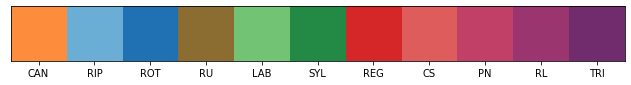

In [10]:
sns.palplot(vitis_label_colors.values())
new_ticks = plt.xticks(range(len(ordered_vitis_labels)), ordered_vitis_labels)

#### 5 yeast strains

In [11]:
# customize label colors for 5 yeast strains

colours = sns.color_palette('Set1', 5)
yeast_label_colors = {lbl: c for lbl, c in zip(yeast_classes, colours)}
datasets['YD']['label_colors'] = yeast_label_colors
datasets['YD']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD']['target']]
datasets['YD2']['label_colors'] = yeast_label_colors
datasets['YD2']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD2']['target']]

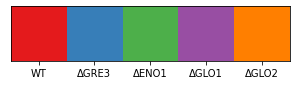

In [12]:
sns.palplot(yeast_label_colors.values())
new_ticks = plt.xticks(range(len(yeast_classes)), yeast_classes)

#### 2 classes of Vitis types

In [13]:
# customize label colors for 2 types of Vitis varieties

colours = [vitis_label_colors['SYL'], vitis_label_colors['TRI']]
vitis_type_classes = datasets['vitis_types']['classes']
vitis_types_label_colors = {lbl: c for lbl, c in zip(vitis_type_classes, colours)}
datasets['vitis_types']['label_colors'] = vitis_types_label_colors
datasets['vitis_types']['sample_colors'] = [vitis_types_label_colors[lbl] for lbl in datasets['vitis_types']['target']]

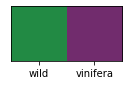

In [14]:
sns.palplot(datasets['vitis_types']['label_colors'].values())
new_ticks = plt.xticks(range(len(datasets['vitis_types']['classes'])), datasets['vitis_types']['classes'])

In [15]:
def styled_sample_labels(sample_names, sample_labels, label_colors):

    meta_table = pd.DataFrame({'label': sample_labels,
                               'sample': sample_names}).set_index('sample').T

    def apply_label_color(val):
        red, green, blue = label_colors[val]
        red, green, blue = int(red*255), int(green*255), int(blue*255)   
        hexcode = '#%02x%02x%02x' % (red, green, blue)
        css = f'background-color: {hexcode}'
        return css
    
    return meta_table.style.applymap(apply_label_color)

In [16]:
parsed = mtl.parse_data(datasets['GD_pos_class2']['data'], labels_loc='label')
y = datasets['GD_pos_class2']['target']
label_colors = datasets['GD_pos_class2']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,CAN,CAN,CAN,CS,CS,CS,LAB,LAB,LAB,PN,PN,PN,REG,REG,REG,RIP,RIP,RIP,RL,RL,RL,ROT,ROT,ROT,RU,RU,RU,SYL,SYL,SYL,TRI,TRI,TRI


In [17]:
parsed = mtl.parse_data(datasets['YD']['data'])
y = datasets['YD']['target']
label_colors = datasets['YD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
label,WT,WT,WT,ΔGRE3,ΔGRE3,ΔGRE3,ΔENO1,ΔENO1,ΔENO1,ΔGLO1,ΔGLO1,ΔGLO1,ΔGLO2,ΔGLO2,ΔGLO2


In [18]:
parsed = mtl.parse_data(datasets['vitis_types']['data'], labels_loc='label')
y = datasets['vitis_types']['target']
label_colors = datasets['vitis_types']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,wild,wild,wild,wild,wild,wild,vinifera,vinifera,vinifera


## Data transformations and pre-treatments

### Each Dataset is transformed to binary or treated by a combination of more established treatments


### Traditional Pre-Treatments

All samples need to have missing value imputation (removing features is optional). In this case, missing features were replaced with half of the minimum intensity of the full dataset.

This can be done with the `NaN_Imputation` function of scaling.py or `fillna_frac_min`(more options available) from metabolinks.

#### 3/4 types of combinations of traditional pre-treatments are made:

(Imp (Ionly) - Only Missing Value Imputation).

##### P Treatment - Missing Value Imputation and Pareto Scaling.

##### NP Treatment - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

##### NGP Treatment - Missing Value Imputation, Normalization by reference feature, Generalized Logarithmic Transformation and Pareto Scaling.

Note: Leucine Enkephalin peak is removed upon normalization.

### Binary Simplification (BinSim)

##### BinSim - `df_to_bool` function (very simple)

In [19]:
# Represents Binary Similarity pre-treatment
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)


def compute_transf(dataset, norm_ref=None, lamb=None):
    "Computes 3 combinations of pre-treatments and BinSim and returns after treatment datasets in a dict."
    
    data = dataset['data']
    
    # Imputation of Missing Values
    imputed = transf.fillna_frac_min(data, fraction=0.5)
    
    # Normalization by a reference feature
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    
    # Pareto Scaling and Generalized Logarithmic Transformation
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    # Store results
    dataset['BinSim'] = df_to_bool(data)
    dataset['Ionly'] = imputed
    dataset['P'] = P
    dataset['NP'] = NP
    dataset['NGP'] = NGP

Human leucine enkephalin (Sigma Aldrich) is the reference feature (internal standard) used for these datasets

[M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da

Search in the Negative GD and Positive GD for the reference feature with `search_for_ref_feat` (details in scaling.py).

### 1st Filtering/Alignment - 1-2 (used in dissertation)

#### Performing different combinations of pre-treatments for the Negative and Positive GD

Search for the reference feature.

In [20]:
# Theoretical mass for negative mode Leucine Enkephalin - 554.262022
# Theoretical mass for positive mode Leucine Enkephalin - 556.276575
Leu_Enk_neg = 554.262022
Leu_Enk_pos = 556.276575

# Reference Feature in the yeast dataset
leu_enk_name = '555.2692975341 Da'

In [21]:
query_datasets = [name for name in datasets if datasets[name]['source']=='grapevine']

for name in query_datasets:
    ds = datasets[name]
    print(f'looking for reference in {name} ...')
    ref_variable = Leu_Enk_neg if ds['mode'] == '-' else Leu_Enk_pos
    closest = transf.find_closest_features(ds['data'], features=[ref_variable])
    if closest[ref_variable] is not None:
        print('Found ref feature', ref_variable)
        delta = closest[ref_variable] - ref_variable
        print(f'In data: {closest[ref_variable]} delta = {delta:.3e}\n')

query_datasets = [name for name in datasets if name.startswith('YD')]

ref_variable = leu_enk_name
for name in query_datasets:
    ds = datasets[name]
    print(f'looking for reference in {name} ...') 
    closest = transf.find_closest_features(ds['data'], features=[ref_variable])
    if closest[ref_variable] is not None:
        print('Found ref feature', ref_variable, '\n')
    else:
        print('Ref feature not found\n')

looking for reference in GD_neg_global2 ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in GD_pos_global2 ...
Found ref feature 556.276575
In data: 556.27657 delta = -5.000e-06

looking for reference in GD_neg_class2 ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in GD_pos_class2 ...
Found ref feature 556.276575
In data: 556.27657 delta = -5.000e-06

looking for reference in vitis_types ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in YD ...
Found ref feature 555.2692975341 Da 

looking for reference in YD2 ...
Found ref feature 555.2692975341 Da 



Apply the different pre-treatments and get the results in their respective dictionaries

In [22]:
for name, ds in datasets.items():
    print(f'Applying pre-processing transformations to data in {name}', end=' ...')
    if name.startswith('YD'):
        ref_variable = leu_enk_name
    else:
        ref_variable = Leu_Enk_neg if ds['mode'] == '-' else Leu_Enk_pos
    
    compute_transf(ds, norm_ref=ref_variable)
    print('done!')

Applying pre-processing transformations to data in GD_neg_global2 ...done!
Applying pre-processing transformations to data in GD_pos_global2 ...done!
Applying pre-processing transformations to data in GD_neg_class2 ...done!
Applying pre-processing transformations to data in GD_pos_class2 ...done!
Applying pre-processing transformations to data in YD ...done!
Applying pre-processing transformations to data in YD2 ...done!
Applying pre-processing transformations to data in vitis_types ...done!


<span style="color:darkred;">------- Checkpoint for API migration</span>

In [23]:
# uncomment to generate checkpoint for old API
#treat_neg2['NGP'].to_csv('treat_neg2_NGP.csv', sep='\t')

roundrobin = pd.read_csv('treat_neg2_NGP.csv', sep='\t', header=[0,1], index_col=0)

# should not raise AssertionError:
assert_frame_equal(roundrobin, datasets['GD_neg_class2']['NGP'].transpose())


# A NOTE on pandas problem:
# assert_frame_equal(roundrobin.transpose(), treat_neg2['NGP'])
# fails the assertion because of m/z value float innacuracy when save to csv.

#roundrobin.transpose()

<span style="color:darkred;">------- END checkpoint for API migration</span>

## Dataset Characteristics

In [24]:
def characterize_dataset(dskey, ds):
#for dskey, ds in datasets.items():
    dataset_chrs = {}
    
    name = ds['name'] # Name of the dataset
    n_samples, n_feats = ds['data'].shape
    n_classes = len(ds['classes'])
       
    Feat_Sample = ds['data'].count(axis=1) # Nº Features in each sample
    Min_Feat_Sample = str(Feat_Sample.min())
    Max_Feat_Sample = str(Feat_Sample.max())
    Average_Feat_Sample = Feat_Sample.mean()
    
    avg_feat_per_sample = int(round(Average_Feat_Sample,0)) # Round
    
    Samp_Class = len(ds['target'])/len(ds['classes'])
    if dskey == 'vitis_types':
        Samp_Class = '15 Vitis vinifera, 18 Wild'
        #Samp_Class = '15 $\it{Vitis}$ $\it{Vinifera}$, 18 Wild'
    else:
        Samp_Class = str(int(Samp_Class))
    
    n_na = ds['data'].isna().sum().sum()
    
    p_na = round(100.0 * n_na / (n_samples * n_feats), 2)
    
    avg_na_per_feature = (n_samples - ds['data'].count(axis=0)).mean()
    avg_na_per_feature = int(round(avg_na_per_feature, 0))
    
    return {'Data set': name,
            '# samples': n_samples,
            '# features': n_feats,
            'features / sample (range)': f'{avg_feat_per_sample} ({Min_Feat_Sample}-{Max_Feat_Sample})',
            '# classes': n_classes,
            'samples / class':Samp_Class,
            '% missing values': p_na,} 
            #'missing values / feature': avg_na_per_feature}

data_characteristics = [characterize_dataset(dskey, ds) for dskey, ds in datasets.items()]
data_characteristics = pd.DataFrame(data_characteristics).set_index('Data set')
data_characteristics

,# samples,# features,features / sample (range),# classes,samples / class,% missing values
Data set,,,,,,
GDg2-,33,3629,658 (367-1002),11,3,81.86
GDg2+,33,7026,1164 (355-2141),11,3,83.43
GDc2-,33,3026,547 (338-919),11,3,81.91
GDc2+,33,4565,824 (215-1670),11,3,81.94
YD 2/15,15,1973,685 (584-757),5,3,65.27
YD 6/15,15,606,468 (383-514),5,3,22.76
Vitis types,33,3026,547 (338-919),2,"15 Vitis vinifera, 18 Wild",81.91


In [25]:
data_characteristics.to_excel('paperimages/dataset_characteristics.xlsx', index=True)

In [26]:
def plot_PCA_old(principaldf, label_colors, label_symbols=None, components=(1,2), var_explained=None, title="PCA", ax=None):
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #with sns.axes_style("whitegrid"):
    ax.axis('equal')
    if var_explained is not None:
        v1, v2 = var_explained[loc_c1], var_explained[loc_c2]
        ax.set_xlabel(f'{col_c1_name} ({100*v1:.1f}%)', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name} ({100*v2:.1f}%)', fontsize = 15)
    else:
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

    unique_labels = principaldf['Label'].unique()
    if label_symbols is None:
        label_symbols = {lbl: 'o' for lbl in unique_labels}

    lbl_handles = {}
    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        hndl = ax.scatter(subset[col_c1_name], subset[col_c2_name],
                          lw=1,ec='black', alpha=0.8,
                          marker=label_symbols[lbl], 
                          s=80, color=label_colors[lbl], label=lbl)
        lbl_handles[lbl] = hndl

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)
    return lbl_handles

def plot_PCA(principaldf, label_colors, components=(1,2), title="PCA", ax=None):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #ax.axis('equal')
    ax.set_xlabel(f'{col_c1_name}')
    ax.set_ylabel(f'{col_c2_name}')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        ax.scatter(subset[col_c1_name],
                   subset[col_c2_name],
                   s=50, color=label_colors[lbl], label=lbl)

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)

def plot_ellipses_PCA(principaldf, label_colors, components=(1,2),ax=None, q=None, nstd=2):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    points = principaldf.iloc[:, [loc_c1, loc_c2]]
    
    #ax.axis('equal')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset_points = points[principaldf['Label']==lbl]
        plot_confidence_ellipse(subset_points, q, nstd, ax=ax, ec=label_colors[lbl], fc='none')


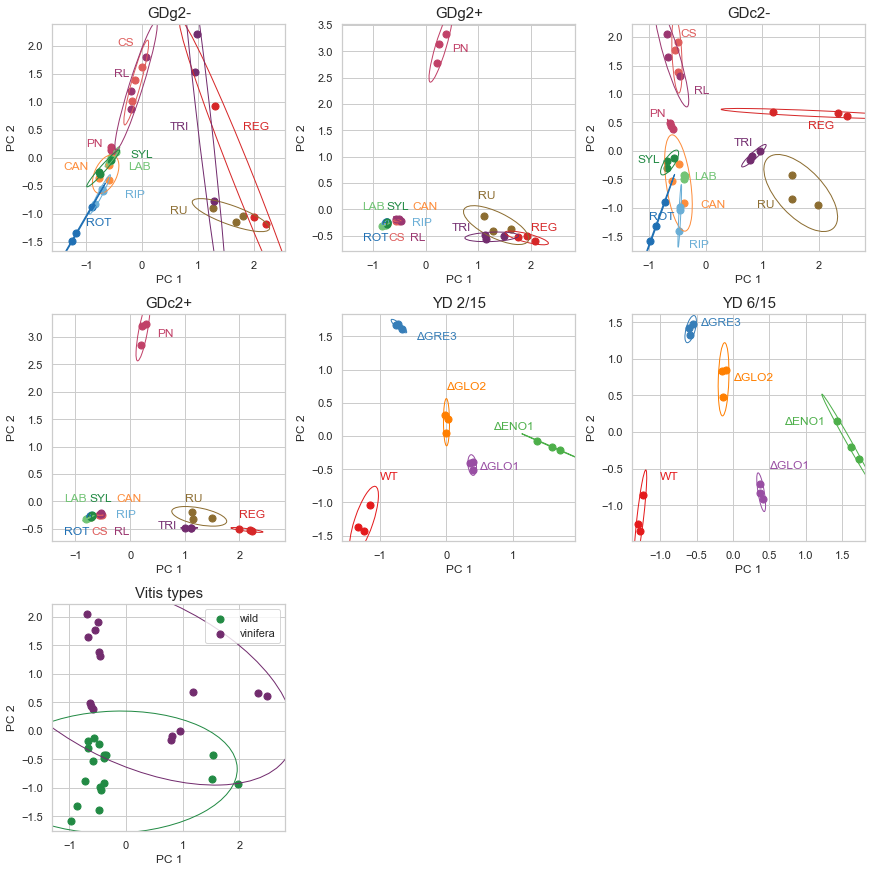

In [27]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(3,3, figsize=(12,12), constrained_layout=True)

        for (dskey, ds), ax in zip(datasets.items(), axs.ravel()):
            df = datasets[dskey]['Ionly']
            tf = transf.FeatureScaler(method='standard')
            df = tf.fit_transform(df)
            #print(df)
            ax.axis('equal')
            principaldf = ma.compute_df_with_PCs(df, n_components=5, whiten=True, labels=datasets[dskey]['target'], return_var_ratios=False)

            lcolors = datasets[dskey]['label_colors']
            plot_PCA(principaldf, lcolors, components=(1,2), title=datasets[dskey]['name'], ax=ax)
            plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)

        axs[2][1].remove()
        axs[2][2].remove()
        #axs[0][1].legend(loc='upper right', ncol=1)
        #axs[1][1].legend(loc='upper right', ncol=1)
        axs[2][0].legend(loc='upper right', ncol=1)
        locs_YD = {'WT':(-1,-0.65),
                   'ΔGRE3':(-0.45, 1.45),
                   'ΔENO1':(0.7, 0.1),
                   'ΔGLO1':(0.5, -0.5),
                   'ΔGLO2':(0,0.7) }
        for lbl in datasets['YD']['classes']:
            axs[1][1].text(*locs_YD[lbl], lbl, c=datasets['YD']['label_colors'][lbl])
        for lbl in datasets['YD']['classes']:
            axs[1][2].text(*locs_YD[lbl], lbl, c=datasets['YD']['label_colors'][lbl])

        locs_GD = {'CAN':(-1.4,-0.2),
                       'CS':(-0.45, 2),
                       'LAB':(-0.25, -0.2),
                       'PN':(-1, 0.2),
                       'REG':(1.8,0.5),
                       'RIP':(-0.3,-0.7),
                       'RL':(-0.5, 1.45),
                       'ROT':(-1, -1.2),
                       'RU':(0.5, -1),
                       'SYL':(-0.2,0),
                       'TRI':(0.5,0.5),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][0].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])

        locs_GD = {'CAN':(-0.1,-1),
                       'CS':(-0.45, 2),
                       'LAB':(-0.2, -0.5),
                       'PN':(-1, 0.6),
                       'REG':(1.8,0.4),
                       'RIP':(-0.3,-1.7),
                       'RL':(-0.2, 1),
                       'ROT':(-1, -1.2),
                       'RU':(0.9, -1),
                       'SYL':(-1.2,-0.2),
                       'TRI':(0.5,0.1),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][2].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])

        locs_GD = {'CAN':(-0.25,0),
                       'CS':(-0.7, -0.6),
                       'LAB':(-1.2, 0),
                       'PN':(0.5, 3),
                       'REG':(2,-0.3),
                       'RIP':(-0.25,-0.3),
                       'RL':(-0.3, -0.6),
                       'ROT':(-1.2,-0.6),
                       'RU':(1, 0),
                       'SYL':(-0.75,0),
                       'TRI':(0.5,-0.5),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[1][0].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])
        
        locs_GD = {'CAN':(-0.25,0),
                       'CS':(-0.7, -0.6),
                       'LAB':(-1.2, 0),
                       'PN':(0.5, 3),
                       'REG':(2,-0.4),
                       'RIP':(-0.25,-0.3),
                       'RL':(-0.3, -0.6),
                       'ROT':(-1.2,-0.6),
                       'RU':(1, 0.2),
                       'SYL':(-0.75,0),
                       'TRI':(0.5,-0.4),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][1].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])
        
        plt.show()
        f.savefig('paperimages/PCAs.pdf', dpi=200)


### Graphical Representation of a portion of the GDc2- dataset after BinSim or NGP pre-treatments

Portion represented: From feature 51 to 150 from the GDc2- dataset.

In [28]:
# Needed extra import
from matplotlib import cm

# For the BinSim legend
Reds = cm.get_cmap('Reds', 20)
Present_Feature = mpatches.Patch(color=Reds(range(20))[-1], label='Present Feature (1)')
Absent_Feature = mpatches.Patch(color='white', label='Absent Feature (0)')

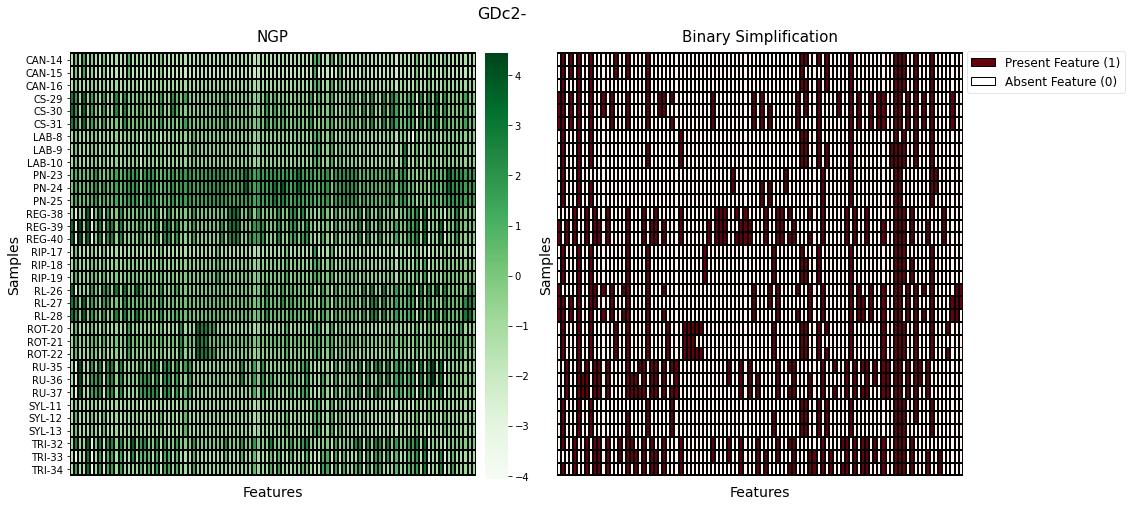

In [29]:
fig, (axl, axr) = plt.subplots(1,2, figsize=(16,8))

cbar_ax = fig.add_axes([0.485, .13, .02, .74]) # For the colorbar

# NGP Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['NGP'].iloc[:,50:150], annot=False, ax=axl, cmap = 'Greens', linewidths = 1, 
                 linecolor = 'black',  xticklabels = False, cbar_ax=cbar_ax)#, norm=LogNorm())#cbar = False,
bottom, top = axl.get_ylim()

axl.set_ylim(bottom + 0.5, top - 0.5)
axl.set_title('NGP', fontsize=15)
axl.set_xlabel('Features', fontsize=14)
axl.set_ylabel('Samples', fontsize=14)

# BinSim Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['BinSim'].iloc[:,50:150], annot=False, ax=axr, cmap = 'Reds', linewidths = 1, 
                 linecolor = 'black', cbar = False, xticklabels = False, yticklabels = False)
bottom, top = axr.get_ylim()
axr.set_ylim(bottom + 0.5, top - 0.5)
axr.set_title('Binary Simplification', fontsize=15)
axr.set_xlabel('Features', fontsize=14)
axr.set_ylabel('Samples', fontsize=14)
axr.legend(handles = [Present_Feature, Absent_Feature], bbox_to_anchor=(1.01, 0.99), loc='upper left', borderaxespad=0., 
           fontsize = 12, ncol=1, frameon=True, framealpha=0.5, facecolor='white')
# Black box around legend colours
for legend_handle in axr.get_legend().legendHandles:
    legend_handle.set_edgecolor('black')
    
fig.suptitle('GDc2-', fontsize = 16, y=0.95)
plt.show()
#fig.savefig('Both_HeatmapGDneg21.pdf', dpi=200, bbox_inches='tight')

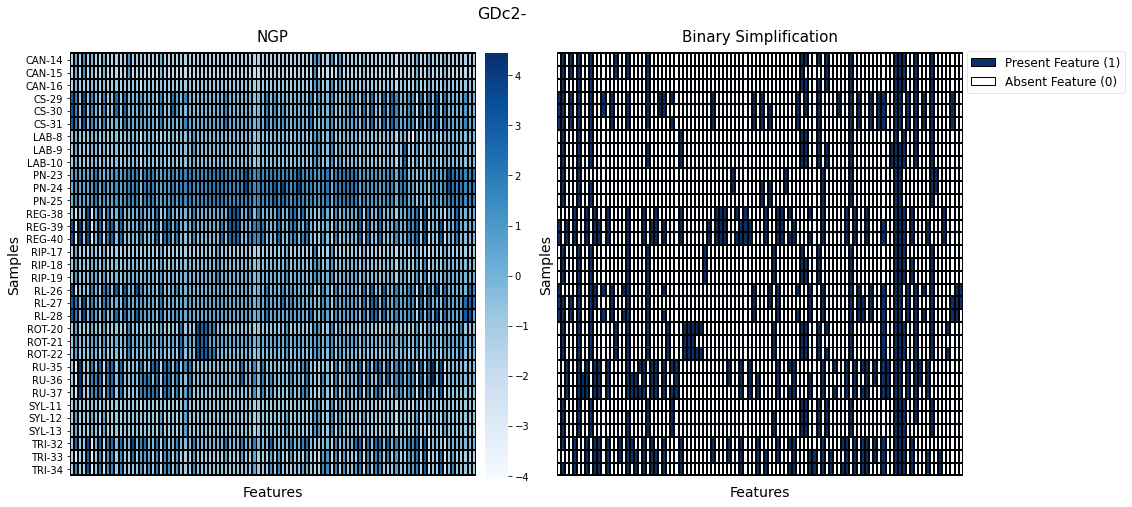

In [30]:
fig, (axl, axr) = plt.subplots(1,2, figsize=(16,8))

cbar_ax = fig.add_axes([0.485, .13, .02, .74]) # For the colorbar

# For the BinSim legend
Blues = cm.get_cmap('Blues', 20)
Present_Feature = mpatches.Patch(color=Blues(range(20))[-1], label='Present Feature (1)')
Absent_Feature = mpatches.Patch(color='white', label='Absent Feature (0)')

# NGP Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['NGP'].iloc[:,50:150], annot=False, ax=axl, cmap = 'Blues', linewidths = 1, 
                 linecolor = 'black',  xticklabels = False, cbar_ax=cbar_ax)#, norm=LogNorm())#cbar = False,
bottom, top = axl.get_ylim()

axl.set_ylim(bottom + 0.5, top - 0.5)
axl.set_title('NGP', fontsize=15)
axl.set_xlabel('Features', fontsize=14)
axl.set_ylabel('Samples', fontsize=14)

# BinSim Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['BinSim'].iloc[:,50:150], annot=False, ax=axr, cmap = 'Blues', linewidths = 1, 
                 linecolor = 'black', cbar = False, xticklabels = False, yticklabels = False)
bottom, top = axr.get_ylim()
axr.set_ylim(bottom + 0.5, top - 0.5)
axr.set_title('Binary Simplification', fontsize=15)
axr.set_xlabel('Features', fontsize=14)
axr.set_ylabel('Samples', fontsize=14)
axr.legend(handles = [Present_Feature, Absent_Feature], bbox_to_anchor=(1.01, 0.99), loc='upper left', borderaxespad=0., 
           fontsize = 12, ncol=1, frameon=True, framealpha=0.5, facecolor='white')
# Black box around legend colours
for legend_handle in axr.get_legend().legendHandles:
    legend_handle.set_edgecolor('black')
    
fig.suptitle('GDc2-', fontsize = 16, y=0.95)
plt.show()
#fig.savefig('Both_HeatmapGDneg21.pdf', dpi=200, bbox_inches='tight')

## Supervised Statistical Analysis

The Supervised Statistical Analysis methods used will be Random Forest and PLS-DA.

The performance of the classifiers will be evaluated by their predictive **accuracy** (which will always be estimated by internal stratified 3-fold cross-validation or 5 -fold cross-validation in vitis_types).

## Random Forests

In [31]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble

### ROC curves

ROC curves are computes for the *vitis_types* classifier only (2-class problem)

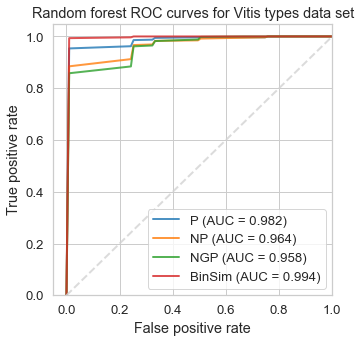

In [32]:
np.random.seed(16)
name = 'vitis_types'
pos_label = 'vinifera'
dataset = datasets[name]
y = dataset['target']
resROC = {}
for treatment in ('P', 'NP', 'NGP', 'BinSim'):
    df = dataset[treatment]
    res = ma.RF_ROC_cv(df, y, pos_label, n_fold=5, n_trees=20, n_iter=20)
    resROC[treatment] = res

p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(1, 1, figsize=(5,5))
        for treatment, color in zip(resROC, p4):
            res = resROC[treatment]
            mean_fpr = res['average fpr']
            mean_tpr = res['average tpr']
            mean_auc = res['mean AUC']
            ax.plot(mean_fpr, mean_tpr, color=color,
                   label=f'{treatment} (AUC = {mean_auc:.3f})',
                   lw=2, alpha=0.8)
        
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='lightgrey', alpha=.8)
        ax.legend()
        ax.set_xlim(None,1)
        ax.set_ylim(0,None)
        ax.set(xlabel='False positive rate', ylabel='True positive rate',
               title="Random forest ROC curves for Vitis types data set")
        plt.show()
        f.savefig('paperimages/ROC_vitis.pdf', dpi=200)

### Optimization of the number of trees

Random Forest models with different number of trees are built to assess when the predictive accuracy of the different models stops increasing with the number of trees.

Grid search of number of trees from 10 to 200 for the random forests. See where the cross-validation estimated predictive accuracy stops improving for each one.

*Takes  some time...*

In [33]:
# NOTE: for debugging
top_tree_in_grid=100
# otherwise
#top_tree_in_grid=200

#Vector with values for the parameter n_estimators
# Models will be built from 10 to 200 trees in 2 tree intervals
values = {'n_estimators': range(10,top_tree_in_grid,5)}

rf = skensemble.RandomForestClassifier(n_estimators=200)
clf = GridSearchCV(rf, values, cv=3)
clf_2class = GridSearchCV(rf, values, cv=5)

# For each dataset,building the Random Forest models with the different number of trees
# and storing the predictive accuracy (estimated by 3-fold cross-validation)
param = []
test_score = []
for name, dataset in datasets.items():
    for treatment in ('P', 'NP', 'NGP', 'BinSim'):
        print('Fitting', name, treatment, '...', end=' ')
        if name == 'vitis_types':
            clf2use = clf_2class
        else:
            clf2use = clf
        clf2use.fit(dataset[treatment], dataset['target'])
        param.append(clf2use.cv_results_['param_n_estimators'])
        test_score.append(clf2use.cv_results_['mean_test_score'])
        print('Done!')

Fitting GD_neg_global2 P ... Done!
Fitting GD_neg_global2 NP ... Done!
Fitting GD_neg_global2 NGP ... Done!
Fitting GD_neg_global2 BinSim ... Done!
Fitting GD_pos_global2 P ... Done!
Fitting GD_pos_global2 NP ... Done!
Fitting GD_pos_global2 NGP ... Done!
Fitting GD_pos_global2 BinSim ... Done!
Fitting GD_neg_class2 P ... Done!
Fitting GD_neg_class2 NP ... Done!
Fitting GD_neg_class2 NGP ... Done!
Fitting GD_neg_class2 BinSim ... Done!
Fitting GD_pos_class2 P ... Done!
Fitting GD_pos_class2 NP ... Done!
Fitting GD_pos_class2 NGP ... Done!
Fitting GD_pos_class2 BinSim ... Done!
Fitting YD P ... Done!
Fitting YD NP ... Done!
Fitting YD NGP ... Done!
Fitting YD BinSim ... Done!
Fitting YD2 P ... Done!
Fitting YD2 NP ... Done!
Fitting YD2 NGP ... Done!
Fitting YD2 BinSim ... Done!
Fitting vitis_types P ... Done!
Fitting vitis_types NP ... Done!
Fitting vitis_types NGP ... Done!
Fitting vitis_types BinSim ... Done!


#### Plots of tree number optimization

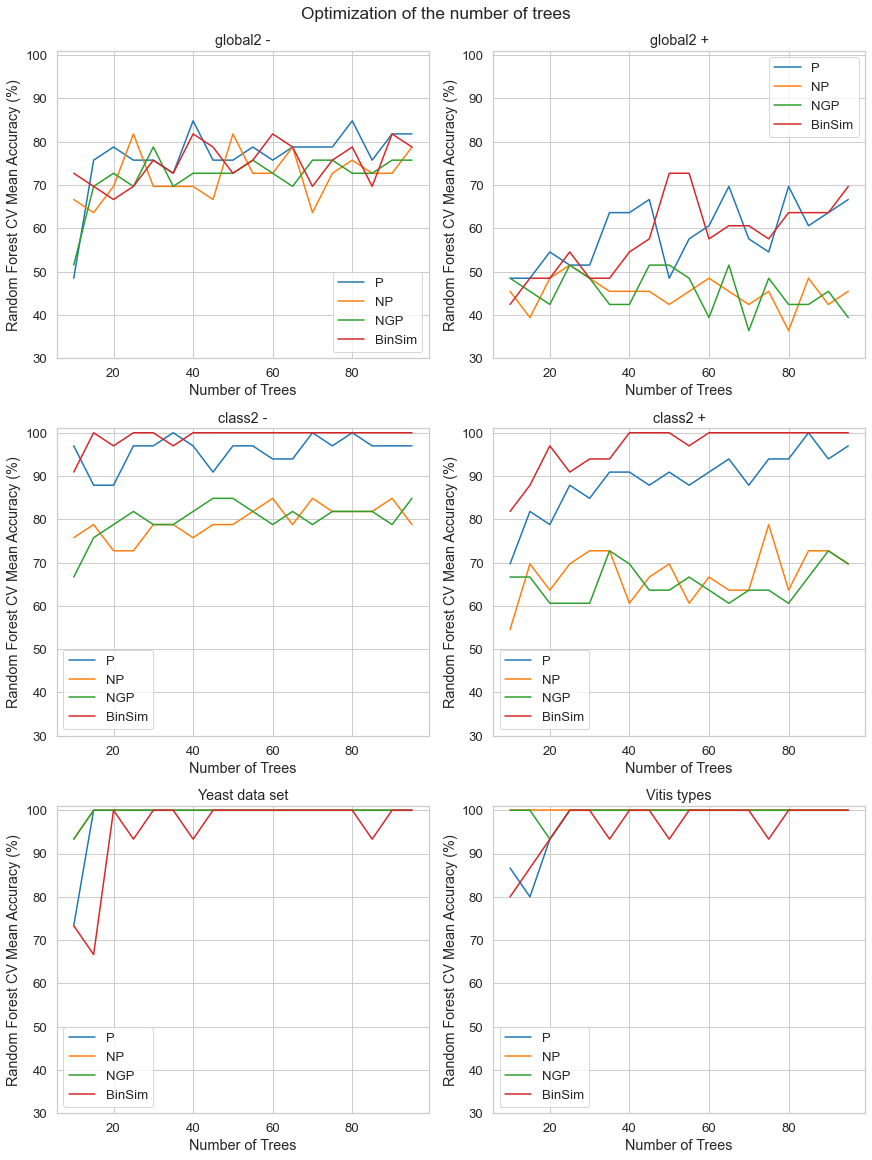

In [34]:
# Plotting the results and adjusting parameters of the plot

def plot_RF_otimization_ntrees(irange, param, test_score, ax=None, ylabel='', title='', ylim=(30,101)):
    if ax is None:
        ax = plt.gca()
    for i in irange:
        ax.plot(param[i], test_score[i]*100)
    ax.set(ylabel=ylabel, xlabel='Number of Trees', ylim=ylim, title=title)
    ax.legend(('P', 'NP', 'NGP', 'BinSim'))

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, axs = plt.subplots(3, 2, figsize=(12,16), constrained_layout=True)
        ranges = [range(i, i+4) for i in (0, 4, 8, 12, 16, 20)]
        titles = ['global2 -', 'global2 +', 'class2 -', 'class2 +', 'Yeast data set', 'Vitis types']
        for irange, title, ax in zip(ranges, titles, axs.ravel()):
        
            plot_RF_otimization_ntrees(irange, param, test_score, ax=ax,
                                       ylabel='Random Forest CV Mean Accuracy (%)',
                                       title=title)

        f.suptitle('Optimization of the number of trees')

        plt.show()

### Random Forest models

Stores predictive accuracy of the models, standard deviation of the predictive accuracy (across the iterations) and an ordered list of the most to least important features (average across the iterations) in building the model according to the Gini Importance calculated by scikit-learn (all estimated by stratified 3-fold cross-validation) of each of the 200 iterations (with different samplings of the 3 folds) of models built for each secondary dataset.

Iterations are made to randomly sample the folds in 3-fold cross-validation - more combinations of training and test samples are used to offset the small (in terms of samples per group) dataset.

Use of the `RF_model_CV` function of multianalysis.py (uses Random Forest algorithm from scikit-learn) where each step of the process is better explained.

In [35]:
# NOTE: for debugging
iter_num=20
# otherwise
#iter_num=100

RF_all = {}

# Application of the Random Forests for each differently-treated dataset
for name, dataset in datasets.items():
    for treatment in ('P', 'NP', 'NGP', 'BinSim'):
        print(f'Fitting random forest for {name} with treatment {treatment}', end=' ...')
        rfname = name + ' ' + treatment
        RF_all[rfname] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}
        n_fold = 5 if name == 'vitis_types' else 3
        
        fit = ma.RF_model_CV(dataset[treatment], dataset['target'], iter_num=iter_num, n_fold=n_fold, n_trees=100)
        RF_all[rfname].update(fit)
        
        print(f'done')    

Fitting random forest for GD_neg_global2 with treatment P ...done
Fitting random forest for GD_neg_global2 with treatment NP ...done
Fitting random forest for GD_neg_global2 with treatment NGP ...done
Fitting random forest for GD_neg_global2 with treatment BinSim ...done
Fitting random forest for GD_pos_global2 with treatment P ...done
Fitting random forest for GD_pos_global2 with treatment NP ...done
Fitting random forest for GD_pos_global2 with treatment NGP ...done
Fitting random forest for GD_pos_global2 with treatment BinSim ...done
Fitting random forest for GD_neg_class2 with treatment P ...done
Fitting random forest for GD_neg_class2 with treatment NP ...done
Fitting random forest for GD_neg_class2 with treatment NGP ...done
Fitting random forest for GD_neg_class2 with treatment BinSim ...done
Fitting random forest for GD_pos_class2 with treatment P ...done
Fitting random forest for GD_pos_class2 with treatment NP ...done
Fitting random forest for GD_pos_class2 with treatment NG

#### Results of the Random Forest - Performance (Predictive Accuracy) 

In [36]:
accuracies = pd.DataFrame({name: RF_all[name]['accuracy'] for name in RF_all})
accuracies

,GD_neg_global2 P,GD_neg_global2 NP,GD_neg_global2 NGP,GD_neg_global2 BinSim,GD_pos_global2 P,GD_pos_global2 NP,GD_pos_global2 NGP,GD_pos_global2 BinSim,GD_neg_class2 P,GD_neg_class2 NP,...,YD NGP,YD BinSim,YD2 P,YD2 NP,YD2 NGP,YD2 BinSim,vitis_types P,vitis_types NP,vitis_types NGP,vitis_types BinSim
0,0.818182,0.666667,0.696970,0.818182,0.606061,0.424242,0.545455,0.666667,1.000000,0.848485,...,1.0,1.0,1.0,1.0,1.0,1.0,0.942857,0.885714,0.876190,1.000000
1,0.909091,0.787879,0.757576,0.787879,0.666667,0.424242,0.545455,0.515152,0.969697,0.757576,...,1.0,1.0,1.0,1.0,1.0,1.0,0.971429,0.885714,0.847619,0.971429
2,0.787879,0.818182,0.757576,0.818182,0.636364,0.484848,0.393939,0.666667,0.969697,0.909091,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.847619,0.842857,1.000000
3,0.757576,0.727273,0.757576,0.787879,0.606061,0.363636,0.454545,0.727273,0.939394,0.848485,...,1.0,1.0,1.0,1.0,1.0,1.0,0.942857,0.876190,0.780952,0.966667
4,0.878788,0.696970,0.727273,0.727273,0.727273,0.454545,0.424242,0.636364,0.969697,0.818182,...,1.0,1.0,1.0,1.0,1.0,1.0,0.971429,0.904762,0.871429,0.971429
5,0.848485,0.727273,0.787879,0.818182,0.636364,0.484848,0.363636,0.666667,1.000000,0.818182,...,1.0,1.0,1.0,1.0,1.0,1.0,0.966667,0.847619,0.933333,1.000000
6,0.757576,0.727273,0.727273,0.787879,0.666667,0.515152,0.484848,0.515152,0.939394,0.848485,...,1.0,1.0,1.0,1.0,1.0,1.0,0.971429,0.876190,0.914286,1.000000
7,0.848485,0.696970,0.757576,0.848485,0.636364,0.515152,0.393939,0.727273,0.969697,0.818182,...,1.0,1.0,1.0,1.0,1.0,1.0,0.966667,0.847619,0.880952,1.000000
8,0.909091,0.727273,0.727273,0.848485,0.636364,0.484848,0.454545,0.545455,1.000000,0.818182,...,1.0,1.0,1.0,1.0,1.0,1.0,0.971429,0.876190,0.857143,0.971429
9,0.878788,0.787879,0.757576,0.757576,0.696970,0.424242,0.424242,0.575758,0.969697,0.848485,...,1.0,1.0,1.0,1.0,1.0,1.0,0.966667,0.885714,0.914286,0.971429


#### Distributions for GDg2+ and GDg2-

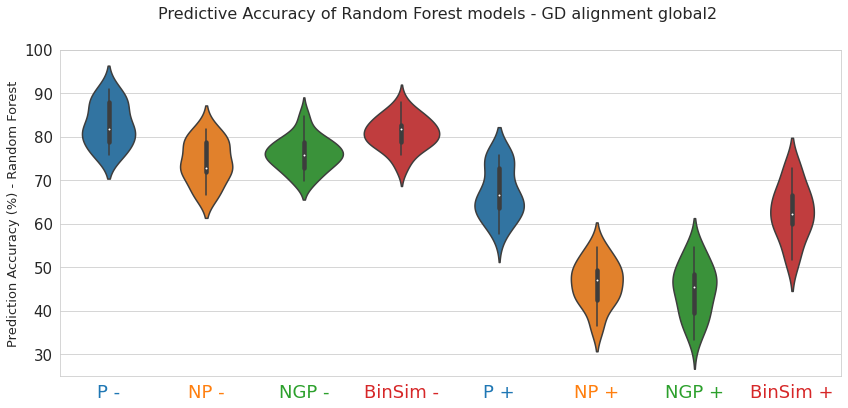

In [37]:
column_names = ['P -', 'NP -', 'NGP -', 'BinSim -', 'P +', 'NP +', 'NGP +', 'BinSim +']
# Violin plot of the distribution of the predictive accuracy (in %) across 100 iterations of randomly sampled folds for each 
# differently-treated dataset and adjustments to the parameters of the plot.

cols2keep = [col for col in accuracies.columns if 'global2' in col]

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(14,6))
    res100 = accuracies[cols2keep] * 100
    res100.columns = column_names

    #colors = ['blue','orange','green','red']
    colors = sns.color_palette('tab10', 4)
    colors.extend(colors)

    sns.violinplot(data=res100, palette=colors)

    plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize=13)
    plt.ylim([25,100])
    ax.tick_params(axis='x', which='major', labelsize = 18)
    ax.tick_params(axis='y', which='major', labelsize = 15)
    for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    f.suptitle('Predictive Accuracy of Random Forest models - GD alignment global2', fontsize=16)
    #plt.title('Yeast Dataset', fontsize = 20)
    #plt.savefig('RF-NGD')

In [38]:
accuracy_stats = pd.DataFrame({'Average accuracy': accuracies.mean(axis=0),
                               'STD': accuracies.std(axis=0)})
accuracy_stats = accuracy_stats.assign(dataset=[RF_all[name]['dataset'] for name in RF_all],
                                       treatment=[RF_all[name]['treatment'] for name in RF_all])
accuracy_stats

,Average accuracy,STD,dataset,treatment
GD_neg_global2 P,0.827273,0.049256,GDg2-,P
GD_neg_global2 NP,0.742424,0.048664,GDg2-,NP
GD_neg_global2 NGP,0.760606,0.037950,GDg2-,NGP
GD_neg_global2 BinSim,0.807576,0.037146,GDg2-,BinSim
GD_pos_global2 P,0.671212,0.058393,GDg2+,P
GD_pos_global2 NP,0.463636,0.052117,GDg2+,NP
GD_pos_global2 NGP,0.448485,0.061083,GDg2+,NGP
GD_pos_global2 BinSim,0.627273,0.063792,GDg2+,BinSim
GD_neg_class2 P,0.974242,0.026518,GDc2-,P
GD_neg_class2 NP,0.843939,0.034446,GDc2-,NP


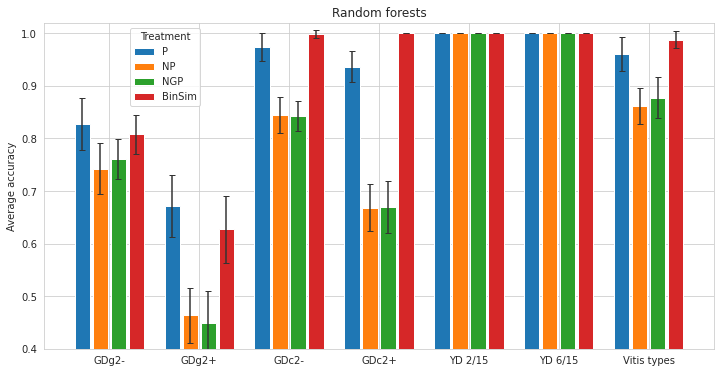

In [39]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = np.arange(len(datasets))  # the label locations
    labels = [datasets[name]['name'] for name in datasets]
    width = 0.17  # the width of the bars
    for i, treatment in enumerate(('P', 'NP', 'NGP', 'BinSim')):
        acc_treatment = accuracy_stats[accuracy_stats['treatment']==treatment]
        offset = - 0.3 + i * 0.2
        rects = ax.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p4[i])
        ax.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                    ls='none', ecolor='0.2', capsize=3)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set(ylabel='Average accuracy', title='Random forests', ylim=(0.4,1.02))
    ax.legend(loc='upper left', title='Treatment', bbox_to_anchor=(0.12, 1))
    f.savefig('paperimages/RF_performance.pdf' , dpi=200)

### Important feature analysis

We take the 2% most important features in each case and calculate the median of the occurrence of those features in samples (`samples_m`), the median of the occurrence of those features in groups/varieties (`groups_n`) and the ratio between these two measures (ratio_m, has a maximum of 3).

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

We also see how many times the importance of the most important feature is greater than the average importance of a feature in each case (`magni`) as well as the % of the model explained (that use) the 2% of the most important features (`explained`).

In [40]:
# Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature,
# calculating % explained by these features (explained) and identification of important features (in negative and positive GD)

def compute_RF_top_feat_stats(name, resdict, fraction=0.02):
    imp_features = resdict['important_features']

    original_data = datasets[resdict['dskey']]['original']
    labels = datasets[resdict['dskey']]['target']

    ratio = []
    nsamples = []
    n_groups = []
    feature_locs = []

    n_features = original_data.shape[1]

    # Top 2% (rounded)
    number = round(fraction * n_features)
    # Calculate, store how many times most important
    # feature is more important than the average importance
    
    resdict['top feature fold importance'] = imp_features[0][1]/(1/n_features)

    top_features = imp_features[:number]
    
    resdict['number top features'] = number
    
    s = 0 # Count the % explained - add for each feature
    for loc, importance in top_features: # Iterate for only the number of features considered as important

        s += importance * 100 

         # fetch feature form unprocessed data
        column = original_data.iloc[:, loc]
        feature_notnull = column.notnull()

        # Count how many samples the feature appears in
        feature_nsamples = feature_notnull.sum()
        nsamples.append(feature_nsamples) 

        # Count how many groups the feature appears in
        group_occurrence = {}        
        for n, f in enumerate(feature_notnull):
            if f == True:
                group_occurrence[labels[n]] = 1
        feature_ngroups = sum(list((group_occurrence.values())))
        n_groups.append(feature_ngroups)

        # Calculate the ratio of number of samples to number of groups the feature appears in
        ratio.append(feature_nsamples/feature_ngroups)

        # Store identification of feature
        feature_locs.append(loc)

    resdict['% top features explanation'] = s

    resdict.update({'n samples': nsamples, 'n groups': n_groups, 'ratios':ratio, 'top features': feature_locs})

for name, resdict in RF_all.items():
    compute_RF_top_feat_stats(name, resdict)


In [41]:
df_RF_stats = {'# samples': {name: np.median(RF_all[name]['n samples']) for name in RF_all},
               '# classes': {name: np.median(RF_all[name]['n groups']) for name in RF_all},
               'samples/classes': {name: np.median(RF_all[name]['ratios']) for name in RF_all},
               '# top 2%': {name: np.median(RF_all[name]['number top features']) for name in RF_all},
               '% model explained': {name: np.median(RF_all[name]['% top features explanation']) for name in RF_all},
               'top feat / average':{name: np.median(RF_all[name]['top feature fold importance']) for name in RF_all}}
df_RF_stats = pd.DataFrame(df_RF_stats)

df_RF_stats

,# samples,# classes,samples/classes,# top 2%,% model explained,top feat / average
GD_neg_global2 P,27.0,10.0,2.818182,73.0,7.944097,5.052190
GD_neg_global2 NP,9.0,5.0,2.250000,73.0,5.330419,3.533339
GD_neg_global2 NGP,9.0,4.0,2.142857,73.0,5.446411,4.271712
GD_neg_global2 BinSim,4.0,2.0,2.500000,73.0,7.487529,6.323329
GD_pos_global2 P,30.0,11.0,2.818182,141.0,15.333105,17.249822
GD_pos_global2 NP,17.0,7.0,2.571429,141.0,9.239472,8.170801
GD_pos_global2 NGP,18.0,7.0,2.555556,141.0,9.275069,7.808323
GD_pos_global2 BinSim,6.0,4.0,2.500000,141.0,11.209207,10.609036
GD_neg_class2 P,16.0,6.0,2.900000,61.0,6.172985,3.734666
GD_neg_class2 NP,8.0,3.0,2.800000,61.0,4.922923,3.257863


#### Occurences by samples and by classes

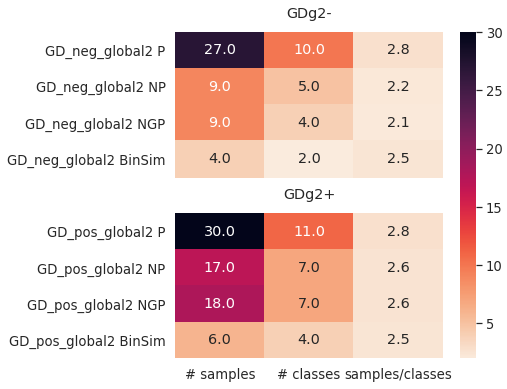

In [42]:
dist_only = df_RF_stats[['# samples', '# classes', 'samples/classes']]
line = pd.DataFrame([], columns=dist_only.columns, index=[''])
display_df = pd.concat([dist_only.iloc[:4], line, dist_only.iloc[4:8]])
#display_df

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(figsize=(6,6))
        hm = sns.heatmap(display_df, annot=True, fmt='.1f', ax=ax, cmap = sns.cm.rocket_r)
        bottom, top = ax.get_ylim()

        plt.text(1.5,-0.5,'GDg2-',horizontalalignment='center', verticalalignment='center')
        plt.text(1.5,4.5,'GDg2+',horizontalalignment='center', verticalalignment='center')
plt.show()

Plotting swarmplots with the distributions of samples important features appear in.

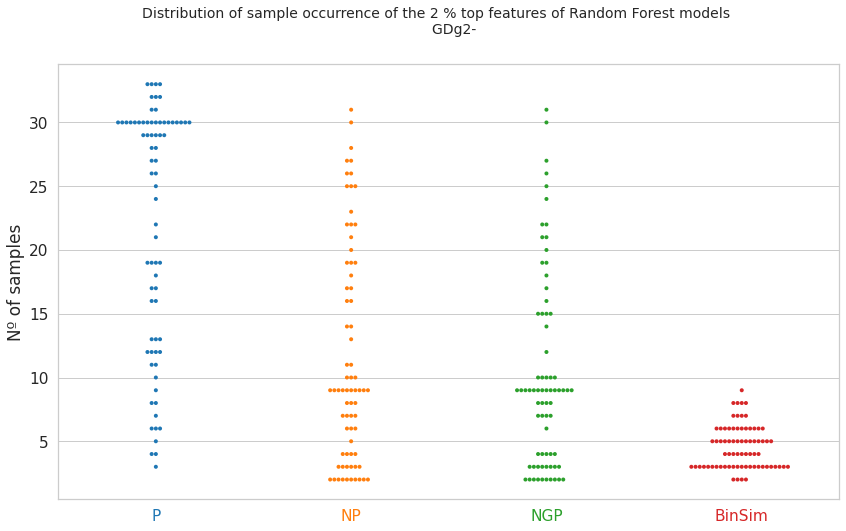

In [43]:
df_RF_sample_dist = {name: RF_all[name]['n samples'] for name in RF_all if RF_all[name]['dskey']=='GD_neg_global2'}
df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)
# Plot the swarm plot and adjust parameters

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_RF_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Nº of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        GDg2-"""

        f.suptitle(title, fontsize=14)
#plt.savefig('RF-NGD-IF')
plt.show()

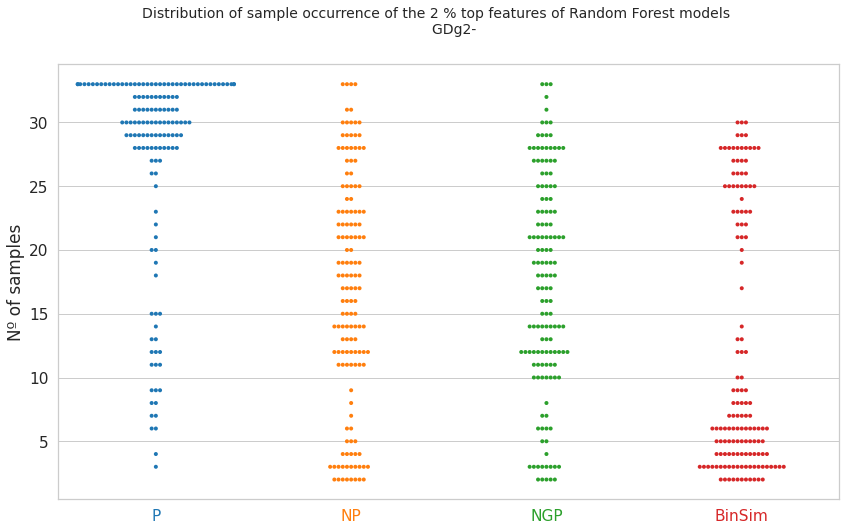

In [44]:
df_RF_sample_dist = {name: RF_all[name]['n samples'] for name in RF_all if RF_all[name]['dskey']=='GD_pos_global2'}
df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)

# Plot the swarm plot and adjust parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_RF_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Nº of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        GDg2-"""

        f.suptitle(title, fontsize=14)
#plt.savefig('RF-NGD-IF')
plt.show()

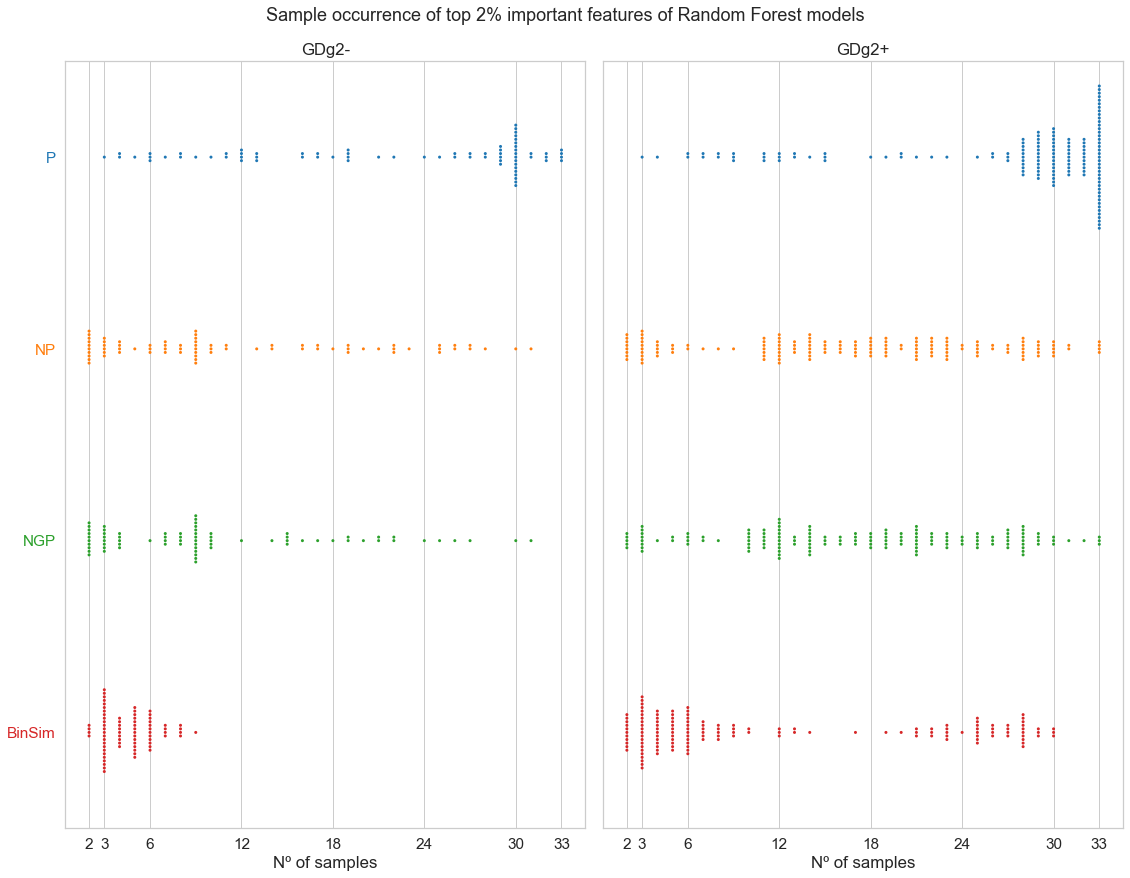

In [45]:
from matplotlib import ticker

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(16,12.5))

        colors = sns.color_palette('tab10', 4)
        tl = ticker.FixedLocator([2, 3, 6, 12, 18, 24, 30, 33])
        
        to_plot = [name for name in RF_all if RF_all[name]['dskey']=='GD_neg_global2']
        df_RF_sample_dist = {RF_all[name]['treatment']: RF_all[name]['n samples'] for name in to_plot}
        df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)
        # Plot the swarm plot and adjust parameters
        sns.swarmplot(data=df_RF_sample_dist, size=3, palette=colors, orient='h', ax=axl)
        title = "GDg2-"
        axl.set(xlabel='Nº of samples', title=title)
        for ticklabel, tickcolor in zip(axl.get_yticklabels(), colors):
            ticklabel.set_color(tickcolor)
        axl.xaxis.set_major_locator(tl)
        
        to_plot = [name for name in RF_all if RF_all[name]['dskey']=='GD_pos_global2']
        df_RF_sample_dist = {RF_all[name]['treatment']: RF_all[name]['n samples'] for name in to_plot}
        df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)
        
        sns.swarmplot(data=df_RF_sample_dist, size=3, palette=colors, orient='h', ax=axr)
        title = "GDg2+"
        axr.set(xlabel='Nº of samples', yticklabels = [], title=title)
        axr.xaxis.set_major_locator(tl)

        f.suptitle("Sample occurrence of top 2% important features of Random Forest models", fontsize=18)
        plt.tight_layout()

        #plt.savefig('RF-NGD-IF')
        plt.show()

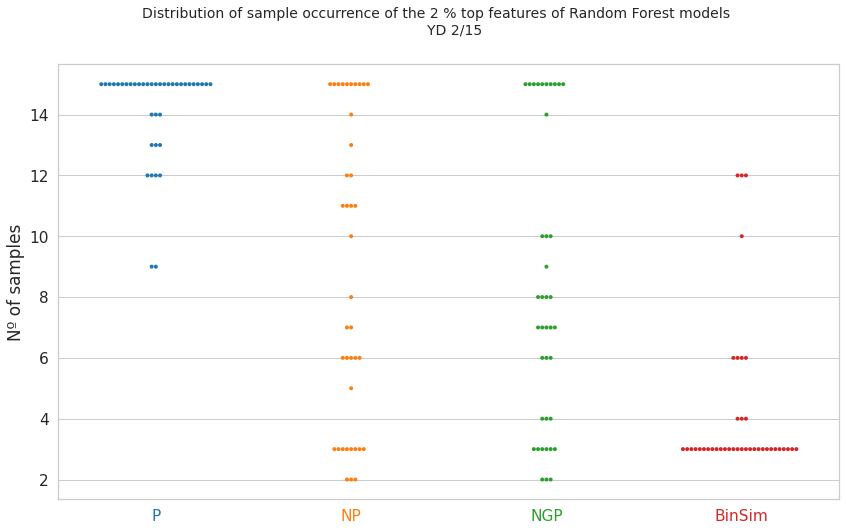

In [46]:
df_RF_sample_dist = {name: RF_all[name]['n samples'] for name in RF_all if RF_all[name]['dskey']=='YD'}
df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)

# Plot the swarm plot and adjust parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_RF_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Nº of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        YD 2/15"""

        f.suptitle(title, fontsize=14)
#plt.savefig('RF-NGD-IF')
plt.show()

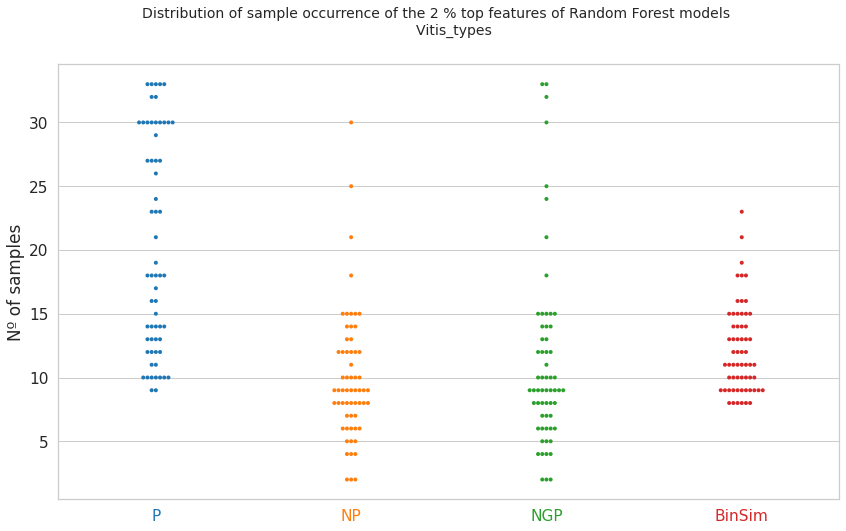

In [47]:
df_RF_sample_dist = {name: RF_all[name]['n samples'] for name in RF_all if RF_all[name]['dskey']=='vitis_types'}
df_RF_sample_dist = pd.DataFrame(df_RF_sample_dist)

# Plot the swarm plot and adjust parameters
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_RF_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Nº of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        Vitis_types"""

        f.suptitle(title, fontsize=14)
#plt.savefig('RF-NGD-IF')
plt.show()

#### Intersections of Important Features used to build each differently-treated dataset - Random Forest

#### Negative Grapevine Dataset - Information (after some calculations) for Fig 3.6

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram

Easier ways to obtain the results directly are available but since it is already done.

In [48]:
# Since we only want counts, let's use the list of locs for the important features
features_as_sets = {name:{} for name in datasets}
for name, rf_dict in RF_all.items():
    features_as_sets[rf_dict['dskey']][rf_dict['treatment']] = set(RF_all[name]['top features'])

In [49]:
# How many Features are in at least one of the sets of important features of the differently-treated dataset
features = features_as_sets['GD_neg_global2']
union = list(itertools.accumulate(features.values(), set.union))[-1]
print('Nº of different features across the sets of important features:', len(union))

# How many Features are in all sets of important features of the differently-treated dataset
intersection = list(itertools.accumulate(features.values(), set.intersection))[-1]
print(f'Nº of features present in all sets of important features: {len(intersection)}\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4), dtype=int), index=features.keys(), columns=features.keys())
for fi in features:
    for fj in features:
        intersec.loc[fi,fj] = len(features[fi].intersection(features[fj]))   
        
# Intersections of 3 of the 4 different sets of important features
for i,j,k in itertools.combinations(features,3):
    print('Sets of features considered:',i,',',j,',',k,'.',
          'Number of features in the 3 sets:', len(set.intersection(features[i], features[j], features[k])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
intersec

Nº of different features across the sets of important features: 236
Nº of features present in all sets of important features: 0

Sets of features considered: P , NP , NGP . Number of features in the 3 sets: 3
Sets of features considered: P , NP , BinSim . Number of features in the 3 sets: 0
Sets of features considered: P , NGP , BinSim . Number of features in the 3 sets: 1
Sets of features considered: NP , NGP , BinSim . Number of features in the 3 sets: 5

Dataframe with the intersection of two set of important features for each pairwise combination:


,P,NP,NGP,BinSim
P,73,7,6,6
NP,7,73,32,6
NGP,6,32,73,8
BinSim,6,6,8,73


#### Positive Grapevine Dataset - Information (after some calculations) for Suppl. Fig. 6.8

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram.

Easier ways to obtain the results directly are available but since it is already done.

In [50]:
# How many Features are in at least one of the sets of important features of the differently-treated dataset
features = features_as_sets['GD_pos_global2']
union = list(itertools.accumulate(features.values(), set.union))[-1]
print('Nº of different features across the sets of important features:', len(union))

# How many Features are in all sets of important features of the differently-treated dataset
intersection = list(itertools.accumulate(features.values(), set.intersection))[-1]
print(f'Nº of features present in all sets of important features: {len(intersection)}\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4), dtype=int), index=features.keys(), columns=features.keys())
for fi in features:
    for fj in features:
        intersec.loc[fi,fj] = len(features[fi].intersection(features[fj]))   
        
# Intersections of 3 of the 4 different sets of important features
for i,j,k in itertools.combinations(features,3):
    print('Sets of features considered:',i,',',j,',',k,'.',
          'Number of features in the 3 sets:', len(set.intersection(features[i], features[j], features[k])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
intersec

Nº of different features across the sets of important features: 386
Nº of features present in all sets of important features: 14

Sets of features considered: P , NP , NGP . Number of features in the 3 sets: 21
Sets of features considered: P , NP , BinSim . Number of features in the 3 sets: 16
Sets of features considered: P , NGP , BinSim . Number of features in the 3 sets: 18
Sets of features considered: NP , NGP , BinSim . Number of features in the 3 sets: 31

Dataframe with the intersection of two set of important features for each pairwise combination:


,P,NP,NGP,BinSim
P,141,30,30,32
NP,30,141,77,40
NGP,30,77,141,41
BinSim,32,40,41,141


In [51]:
# How many Features are in at least one of the sets of important features of the differently-treated dataset
features = features_as_sets['GD_neg_class2']
union = list(itertools.accumulate(features.values(), set.union))[-1]
print('Nº of different features across the sets of important features:', len(union))

# How many Features are in all sets of important features of the differently-treated dataset
intersection = list(itertools.accumulate(features.values(), set.intersection))[-1]
print(f'Nº of features present in all sets of important features: {len(intersection)}\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4), dtype=int), index=features.keys(), columns=features.keys())
for fi in features:
    for fj in features:
        intersec.loc[fi,fj] = len(features[fi].intersection(features[fj]))   
        
# Intersections of 3 of the 4 different sets of important features
for i,j,k in itertools.combinations(features,3):
    print('Sets of features considered:',i,',',j,',',k,'.',
          'Number of features in the 3 sets:', len(set.intersection(features[i], features[j], features[k])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
intersec

Nº of different features across the sets of important features: 193
Nº of features present in all sets of important features: 2

Sets of features considered: P , NP , NGP . Number of features in the 3 sets: 7
Sets of features considered: P , NP , BinSim . Number of features in the 3 sets: 4
Sets of features considered: P , NGP , BinSim . Number of features in the 3 sets: 2
Sets of features considered: NP , NGP , BinSim . Number of features in the 3 sets: 2

Dataframe with the intersection of two set of important features for each pairwise combination:


,P,NP,NGP,BinSim
P,61,11,10,10
NP,11,61,19,8
NGP,10,19,61,6
BinSim,10,8,6,61


In [52]:
# How many Features are in at least one of the sets of important features of the differently-treated dataset
features = features_as_sets['GD_pos_class2']
union = list(itertools.accumulate(features.values(), set.union))[-1]
print('Nº of different features across the sets of important features:', len(union))

# How many Features are in all sets of important features of the differently-treated dataset
intersection = list(itertools.accumulate(features.values(), set.intersection))[-1]
print(f'Nº of features present in all sets of important features: {len(intersection)}\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4), dtype=int), index=features.keys(), columns=features.keys())
for fi in features:
    for fj in features:
        intersec.loc[fi,fj] = len(features[fi].intersection(features[fj]))   
        
# Intersections of 3 of the 4 different sets of important features
for i,j,k in itertools.combinations(features,3):
    print('Sets of features considered:',i,',',j,',',k,'.',
          'Number of features in the 3 sets:', len(set.intersection(features[i], features[j], features[k])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
intersec

Nº of different features across the sets of important features: 264
Nº of features present in all sets of important features: 8

Sets of features considered: P , NP , NGP . Number of features in the 3 sets: 10
Sets of features considered: P , NP , BinSim . Number of features in the 3 sets: 12
Sets of features considered: P , NGP , BinSim . Number of features in the 3 sets: 11
Sets of features considered: NP , NGP , BinSim . Number of features in the 3 sets: 14

Dataframe with the intersection of two set of important features for each pairwise combination:


,P,NP,NGP,BinSim
P,91,16,15,27
NP,16,91,41,20
NGP,15,41,91,20
BinSim,27,20,20,91


## PLS-DA - Classifiers

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong) with one-hot encoding.

PLS-DA models were built using the PLSRegression module of scikit-learn while imposing a decision rule where the group corresponding to the maximum value in the predicted regression vector (one value for each group) obtained for a test sample (ypred) is chosen. 

### Optimization - Search for the best number of components of PLS model

The number of components were optimized by observing the score metric of the PLSRegression of scikit learn, that is, the 1 - PRESS/SS or Q2 of models built with 1 to n components.

PRESS - Predictive Residual Sum of Squares
SS - residual Sum of Squares

Strategy: Perform PLS-DA with different number of components and observe the score (given directly by the method score, inverse relation to the mean-squared error (MSE)) of the models built estimated with stratified 3-fold cross-validation. Then plot the different results obtained and see at which point (number of components) the score starts approaching a "stable maximum value".

To observe details of the `optim_PLS` function - performs PLS analysis and obtains the results stated above with number of components defined from 1 to max_comp - see multianalysis.py file. 

These regression metrics are not suitable to evaluate the performance of the classifier, they were just used to optimize the number of components to build the final PLS-DA models.

In [53]:
%%capture --no-stdout
# above is to supress PLS warnings

# NOTE: for debugging
max_comp=10
# otherwise
#max_comp=50

# Store Results
PLS_optim = {}

# Build and extract metrics from models build with different number of components by using the optim_PLS function.
for name, dataset in datasets.items():
    for treatment in ('P', 'NP', 'NGP', 'BinSim'):
        print(f'Fitting PLS-DA model for {name} with treatment {treatment}', end=' ...')
        plsdaname = name + ' ' + treatment
        PLS_optim[plsdaname] = {'dskey': name, 'dataset':dataset['name'], 'treatment':treatment}
        n_fold = 5 if name == 'vitis_types' else 3
        optim = ma.optim_PLSDA_n_components(dataset[treatment], dataset['target'],
                                            max_comp=max_comp, n_fold=n_fold).CVscores
        PLS_optim[plsdaname]['CV_scores'] = optim
        print(f'done')


Fitting PLS-DA model for GD_neg_global2 with treatment P ...done
Fitting PLS-DA model for GD_neg_global2 with treatment NP ...done
Fitting PLS-DA model for GD_neg_global2 with treatment NGP ...done
Fitting PLS-DA model for GD_neg_global2 with treatment BinSim ...done
Fitting PLS-DA model for GD_pos_global2 with treatment P ...done
Fitting PLS-DA model for GD_pos_global2 with treatment NP ...done
Fitting PLS-DA model for GD_pos_global2 with treatment NGP ...done
Fitting PLS-DA model for GD_pos_global2 with treatment BinSim ...done
Fitting PLS-DA model for GD_neg_class2 with treatment P ...done
Fitting PLS-DA model for GD_neg_class2 with treatment NP ...done
Fitting PLS-DA model for GD_neg_class2 with treatment NGP ...done
Fitting PLS-DA model for GD_neg_class2 with treatment BinSim ...done
Fitting PLS-DA model for GD_pos_class2 with treatment P ...done
Fitting PLS-DA model for GD_pos_class2 with treatment NP ...done
Fitting PLS-DA model for GD_pos_class2 with treatment NGP ...done
Fitti

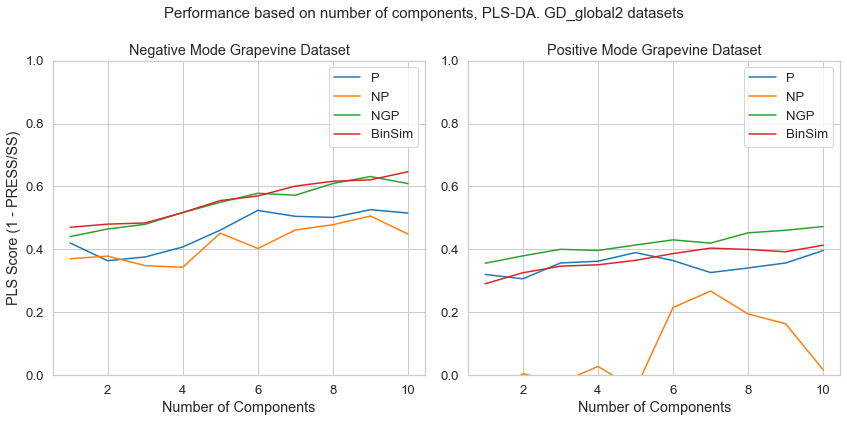

In [54]:
# Plotting the results and adjusting plot parameters


with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (12,6))
        plt.suptitle('Performance based on number of components, PLS-DA. GD_global2 datasets', fontsize=15)

        for name, data in PLS_optim.items():

            if data['dskey'] == 'GD_neg_global2':
                # Negative Grapevine Dataset
                axl.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axl.set(xlabel='Number of Components',
                        ylabel='PLS Score (1 - PRESS/SS)',
                        title='Negative Mode Grapevine Dataset')
                axl.legend()
                axl.set_ylim([0, 1])

            if data['dskey'] == 'GD_pos_global2':
                # Positive Grapevine Dataset
                axr.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axr.set(xlabel='Number of Components',
                        ylabel='',
                        title='Positive Mode Grapevine Dataset')
                axr.legend()
                axr.set_ylim([0, 1])
        plt.tight_layout()
        plt.show()

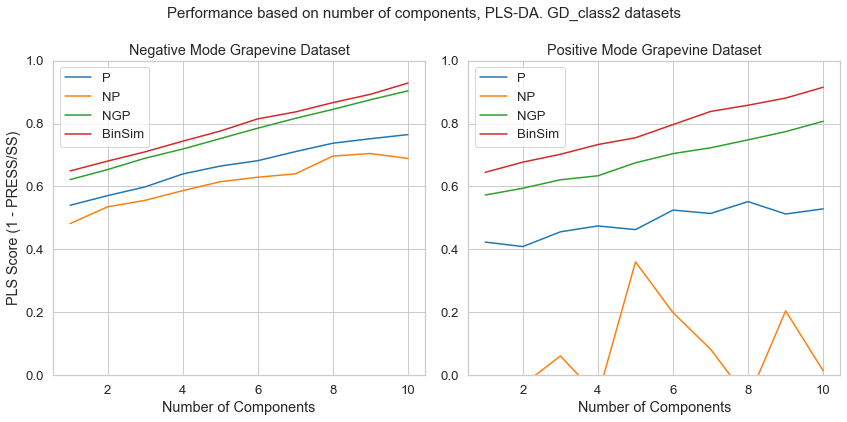

In [55]:
# Plotting the results and adjusting plot parameters


with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (12,6))
        plt.suptitle('Performance based on number of components, PLS-DA. GD_class2 datasets', fontsize=15)

        for name, data in PLS_optim.items():

            if data['dskey'] == 'GD_neg_class2':
                # Negative Grapevine Dataset
                axl.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axl.set(xlabel='Number of Components',
                        ylabel='PLS Score (1 - PRESS/SS)',
                        title='Negative Mode Grapevine Dataset')
                axl.legend()
                axl.set_ylim([0, 1])

            if data['dskey'] == 'GD_pos_class2':
                # Positive Grapevine Dataset
                axr.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axr.set(xlabel='Number of Components',
                        ylabel='',
                        title='Positive Mode Grapevine Dataset')
                axr.legend()
                axr.set_ylim([0, 1])
        plt.tight_layout()
        plt.show()

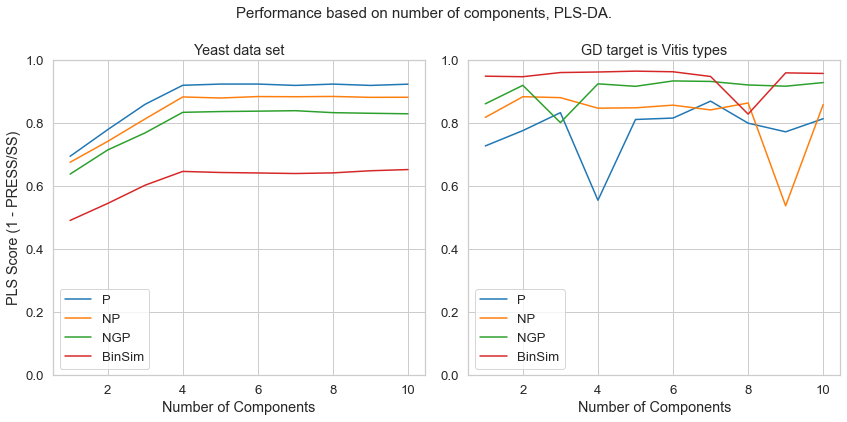

In [56]:
# Plotting the results and adjusting plot parameters


with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (12,6))
        plt.suptitle('Performance based on number of components, PLS-DA.', fontsize=15)

        for name, data in PLS_optim.items():

            if data['dskey'] == 'YD':
                # Negative Grapevine Dataset
                axl.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axl.set(xlabel='Number of Components',
                        ylabel='PLS Score (1 - PRESS/SS)',
                        title='Yeast data set')
                axl.legend()
                axl.set_ylim([0, 1])

            if data['dskey'] == 'vitis_types':
                # Positive Grapevine Dataset
                axr.plot(range(1, len(data['CV_scores']) + 1), data['CV_scores'], label=data['treatment'])
                axr.set(xlabel='Number of Components',
                        ylabel='',
                        title='GD target is Vitis types')
                axr.legend()
                axr.set_ylim([0, 1])
        plt.tight_layout()
        plt.show()

For the differently-treated Negative Grapevine Datasets (Alignment 1-2), PLS-DA models were built with 11 components.

For the Yeast dataset and GD for Vitis types, PLS-DA models were built with 11 components.

For the differently-treated Positive Grapevine Datasets (Alignment 1-2), PLS-DA models were built with 13 components.

### Application of PLS-DA

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule. Models were evaluated according to their predictive accuracy estimated by 3-fold cross-validation.

Use of function `model_PLSDA` of multianalysis.py file. See this file to see the application of this function more in-depth (used `PLSRegression` from scikit-learn).

3 different feature importance metrics (feat_type):

- VIP (Variable Importance/Influence in Projection) - used in dissertation (slowest)
- Coef. (regression coefficients - sum)
- Weights (Sum of the X-weights for each feature)

In [57]:
%%capture --no-stdout

PLSDA_all = {}

# NOTE: for debugging
iter_num=10
# otherwise
#iter_num=200

# For each differently-treated dataset, fit PLS-DA models on 200 randomly sampled folds (for stratified 3-fold cross validation)
# Store results in dictionaries (results for 200 iterations).

for name, dataset in datasets.items():
    for treatment in ('P', 'NP', 'NGP', 'BinSim'):
        print(f'Fitting a PLS-DA model to {name} with treatment {treatment}', end=' ...')
        plsdaname = name + ' ' + treatment
        PLSDA_all[plsdaname] = {'dskey': name, 'dataset': dataset['name'], 'treatment':treatment}
        n_comp = 11 if name.startswith('GD') else 6
        n_fold = 5 if name == 'vitis_types' else 3
        fit = ma.PLSDA_model_CV(dataset[treatment], dataset['target'],
                                n_comp=n_comp, n_fold=n_fold,
                                iter_num=iter_num,
                                feat_type='VIP')
        PLSDA_all[plsdaname].update(fit)
        print(f'done')     



Fitting a PLS-DA model to GD_neg_global2 with treatment P ...done
Fitting a PLS-DA model to GD_neg_global2 with treatment NP ...done
Fitting a PLS-DA model to GD_neg_global2 with treatment NGP ...done
Fitting a PLS-DA model to GD_neg_global2 with treatment BinSim ...done
Fitting a PLS-DA model to GD_pos_global2 with treatment P ...done
Fitting a PLS-DA model to GD_pos_global2 with treatment NP ...done
Fitting a PLS-DA model to GD_pos_global2 with treatment NGP ...done
Fitting a PLS-DA model to GD_pos_global2 with treatment BinSim ...done
Fitting a PLS-DA model to GD_neg_class2 with treatment P ...done
Fitting a PLS-DA model to GD_neg_class2 with treatment NP ...done
Fitting a PLS-DA model to GD_neg_class2 with treatment NGP ...done
Fitting a PLS-DA model to GD_neg_class2 with treatment BinSim ...done
Fitting a PLS-DA model to GD_pos_class2 with treatment P ...done
Fitting a PLS-DA model to GD_pos_class2 with treatment NP ...done
Fitting a PLS-DA model to GD_pos_class2 with treatment NG

#### Results of the PLS-DA - Performance (Predictive Accuracy) 

#### Distribution for GDg2-, GDg2+, GDc2-, GDc2+

In [58]:
accuracies = pd.DataFrame({name: PLSDA_all[name]['accuracy'] for name in PLSDA_all})
accuracies

,GD_neg_global2 P,GD_neg_global2 NP,GD_neg_global2 NGP,GD_neg_global2 BinSim,GD_pos_global2 P,GD_pos_global2 NP,GD_pos_global2 NGP,GD_pos_global2 BinSim,GD_neg_class2 P,GD_neg_class2 NP,...,YD NGP,YD BinSim,YD2 P,YD2 NP,YD2 NGP,YD2 BinSim,vitis_types P,vitis_types NP,vitis_types NGP,vitis_types BinSim
0,0.696970,0.757576,0.818182,0.878788,0.666667,0.757576,0.878788,0.757576,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,1.000000,1.000000
1,0.727273,0.666667,0.818182,0.878788,0.666667,0.727273,0.818182,0.727273,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,1.000000,1.000000
2,0.757576,0.696970,0.787879,0.878788,0.727273,0.787879,0.818182,0.909091,0.939394,0.909091,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.939394,0.969697,1.000000
3,0.727273,0.666667,0.848485,0.848485,0.666667,0.787879,0.848485,0.818182,0.939394,0.878788,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,1.000000,1.000000
4,0.727273,0.787879,0.818182,0.787879,0.696970,0.848485,0.818182,0.727273,0.939394,0.909091,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.939394,1.000000,1.000000
5,0.757576,0.757576,0.757576,0.848485,0.696970,0.727273,0.818182,0.909091,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,1.000000,1.000000
6,0.727273,0.787879,0.757576,0.818182,0.696970,0.636364,0.818182,0.787879,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,1.000000,1.000000
7,0.727273,0.727273,0.818182,0.818182,0.757576,0.696970,0.818182,0.757576,0.939394,0.909091,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,1.000000,1.000000
8,0.757576,0.757576,0.818182,0.818182,0.727273,0.666667,0.818182,0.848485,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.939394,0.969697,0.969697,0.909091
9,0.727273,0.696970,0.787879,0.818182,0.757576,0.727273,0.848485,0.878788,0.939394,0.939394,...,1.0,1.0,1.0,1.0,1.0,1.0,0.969697,0.969697,0.969697,1.000000


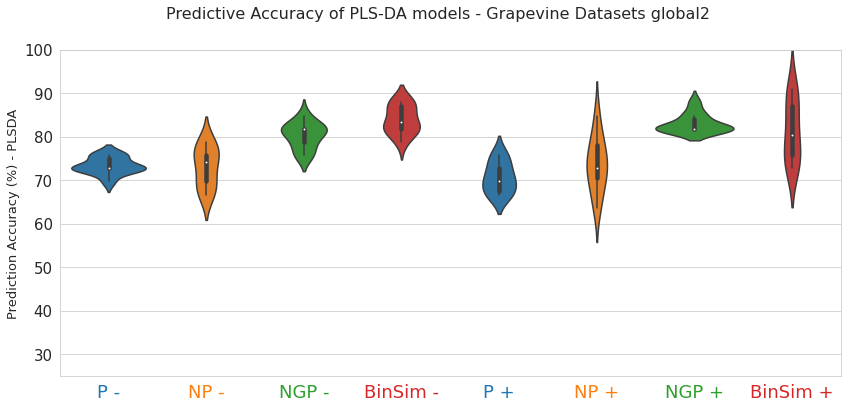

In [59]:
column_names = ['P -', 'NP -', 'NGP -', 'BinSim -', 'P +', 'NP +', 'NGP +', 'BinSim +']
# Violin plot of the distribution of the predictive accuracy (in %) across 100 iterations of randomly sampled folds for each 
# differently-treated dataset and adjustments to the parameters of the plot.

cols2keep = [col for col in accuracies.columns if 'global2' in col]

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(14,6))
    res100 = accuracies[cols2keep] * 100
    res100.columns = column_names

    #colors = ['blue','orange','green','red']
    colors = sns.color_palette('tab10', 4)
    colors.extend(colors)

    sns.violinplot(data=res100, palette=colors)

    plt.ylabel('Prediction Accuracy (%) - PLSDA', fontsize=13)
    plt.ylim([25,100])
    ax.tick_params(axis='x', which='major', labelsize = 18)
    ax.tick_params(axis='y', which='major', labelsize = 15)
    for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    f.suptitle('Predictive Accuracy of PLS-DA models - Grapevine Datasets global2', fontsize=16)
    #plt.title('Yeast Dataset', fontsize = 20)
    #plt.savefig('RF-NGD')

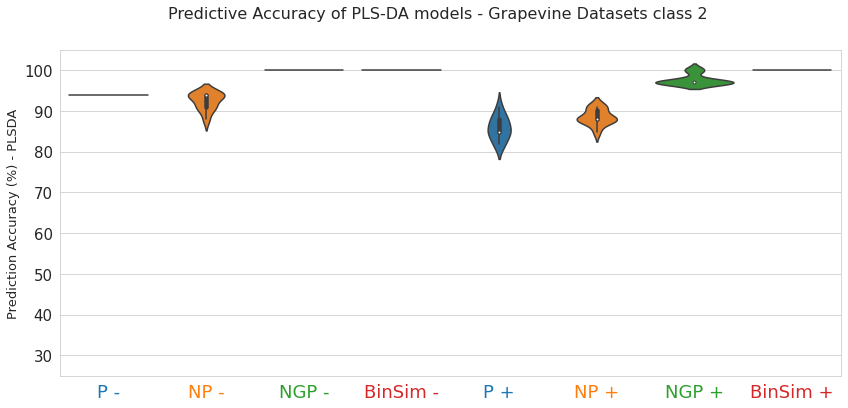

In [60]:
column_names = ['P -', 'NP -', 'NGP -', 'BinSim -', 'P +', 'NP +', 'NGP +', 'BinSim +']
# Violin plot of the distribution of the predictive accuracy (in %) across 100 iterations of randomly sampled folds for each 
# differently-treated dataset and adjustments to the parameters of the plot.

cols2keep = [col for col in accuracies.columns if 'class2' in col]

with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(14,6))
    res100 = accuracies[cols2keep] * 100
    res100.columns = column_names

    #colors = ['blue','orange','green','red']
    colors = sns.color_palette('tab10', 4)
    colors.extend(colors)

    sns.violinplot(data=res100, palette=colors)

    plt.ylabel('Prediction Accuracy (%) - PLSDA', fontsize=13)
    plt.ylim([25,105])
    ax.tick_params(axis='x', which='major', labelsize = 18)
    ax.tick_params(axis='y', which='major', labelsize = 15)
    for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
        ticklabel.set_color(tickcolor)
    f.suptitle('Predictive Accuracy of PLS-DA models - Grapevine Datasets class 2', fontsize=16)
    #plt.title('Yeast Dataset', fontsize = 20)
    #plt.savefig('RF-NGD')

#### Info for Fig. 3.5 and Suppl. Fig. 6.6 and other info

In [61]:
accuracy_stats = pd.DataFrame({'Average accuracy': accuracies.mean(axis=0),
                               'STD': accuracies.std(axis=0)})
accuracy_stats = accuracy_stats.assign(dataset=[PLSDA_all[name]['dataset'] for name in PLSDA_all],
                                       treatment=[PLSDA_all[name]['treatment'] for name in PLSDA_all])
accuracy_stats

,Average accuracy,STD,dataset,treatment
GD_neg_global2 P,0.733333,0.019165,GDg2-,P
GD_neg_global2 NP,0.730303,0.046178,GDg2-,NP
GD_neg_global2 NGP,0.803030,0.029449,GDg2-,NGP
GD_neg_global2 BinSim,0.839394,0.032102,GDg2-,BinSim
GD_pos_global2 P,0.706061,0.035136,GDg2+,P
GD_pos_global2 NP,0.736364,0.062349,GDg2+,NP
GD_pos_global2 NGP,0.830303,0.021188,GDg2+,NGP
GD_pos_global2 BinSim,0.812121,0.071139,GDg2+,BinSim
GD_neg_class2 P,0.939394,0.000000,GDc2-,P
GD_neg_class2 NP,0.924242,0.021427,GDc2-,NP


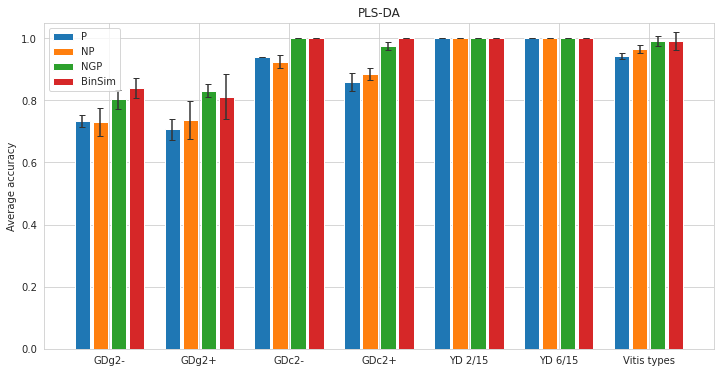

In [62]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    x = np.arange(len(datasets))  # the label locations
    labels = [datasets[name]['name'] for name in datasets]
    width = 0.17  # the width of the bars
    for i, treatment in enumerate(('P', 'NP', 'NGP', 'BinSim')):
        acc_treatment = accuracy_stats[accuracy_stats['treatment']==treatment]
        offset = - 0.3 + i * 0.2
        rects = ax.bar(x + offset, acc_treatment['Average accuracy'], width, label=treatment, color = p4[i])
        ax.errorbar(x + offset, y=acc_treatment['Average accuracy'], yerr=acc_treatment['STD'],
                    ls='none', ecolor='0.2', capsize=3)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set(ylabel='Average accuracy', title='PLS-DA', ylim=(0,1.05))
    ax.legend(loc='upper left')
    f.savefig('paperimages/PLSDA_performance.pdf' , dpi=200)

### Characteristics of the features considered as important in the differently-treated datasets (Negative and Positive)

Same process as applied for Random Forest.

In [63]:
def compute_PLSDA_top_feat_stats(name, resdict, fraction=0.02):
    imp_features = resdict['important_features']

    original_data = datasets[resdict['dskey']]['original']
    labels = datasets[resdict['dskey']]['target']

    ratio = []
    nsamples = []
    n_groups = []
    feature_locs = []

    n_features = original_data.shape[1]

    # Top 2% (rounded)
    number = round(fraction * n_features)
    # Calculate, store how many times most important
    # feature is more important than the average importance
    
    resdict['top feature fold importance'] = imp_features[0][1]

    top_features = imp_features[:number]
    
    resdict['number top features'] = number
    
    s = 0 # Count the % explained - add for each feature
    for loc, importance in top_features: # Iterate for only the number of features considered as important

        s += importance * 100 / n_features

         # fetch feature form unprocessed data
        column = original_data.iloc[:, loc]
        feature_notnull = column.notnull()

        # Count how many samples the feature appears in
        feature_nsamples = feature_notnull.sum()
        nsamples.append(feature_nsamples) 

        # Count how many groups the feature appears in
        group_occurrence = {}        
        for n, f in enumerate(feature_notnull):
            if f == True:
                group_occurrence[labels[n]] = 1
        feature_ngroups = sum(list((group_occurrence.values())))
        n_groups.append(feature_ngroups)

        # Calculate the ratio of number of samples to number of groups the feature appears in
        ratio.append(feature_nsamples/feature_ngroups)

        # Store identification of feature
        feature_locs.append(loc)

    resdict['% top features explanation'] = s

    resdict.update({'n samples': nsamples, 'n groups': n_groups, 'ratios':ratio, 'top features': feature_locs})

for name, resdict in PLSDA_all.items():
    compute_PLSDA_top_feat_stats(name, resdict)


In [64]:
df_PLSDA_stats = {'# samples': {name: np.median(PLSDA_all[name]['n samples']) for name in PLSDA_all},
               '# classes': {name: np.median(PLSDA_all[name]['n groups']) for name in PLSDA_all},
               'samples/classes': {name: np.median(PLSDA_all[name]['ratios']) for name in PLSDA_all},
               '# top 2%': {name: np.median(PLSDA_all[name]['number top features']) for name in PLSDA_all},
               '% model explained': {name: np.median(PLSDA_all[name]['% top features explanation']) for name in PLSDA_all},
               'top feat / average':{name: np.median(PLSDA_all[name]['top feature fold importance']) for name in PLSDA_all}}
df_PLSDA_stats = pd.DataFrame(df_PLSDA_stats)

df_PLSDA_stats

,# samples,# classes,samples/classes,# top 2%,% model explained,top feat / average
GD_neg_global2 P,15.0,6.0,2.444444,73.0,8.730675,14.217236
GD_neg_global2 NP,13.0,6.0,2.400000,73.0,8.529153,14.997117
GD_neg_global2 NGP,9.0,5.0,2.000000,73.0,3.730281,2.991255
GD_neg_global2 BinSim,14.0,6.0,2.285714,73.0,3.469834,2.044536
GD_pos_global2 P,27.0,10.0,2.909091,141.0,8.116121,12.955503
GD_pos_global2 NP,21.0,9.0,2.727273,141.0,8.185450,13.325389
GD_pos_global2 NGP,21.0,9.0,2.500000,141.0,5.182105,4.782330
GD_pos_global2 BinSim,16.0,8.0,2.333333,141.0,3.935168,2.473431
GD_neg_class2 P,15.0,5.0,2.800000,61.0,8.891079,13.396241
GD_neg_class2 NP,13.0,5.0,2.875000,61.0,8.819159,13.005413


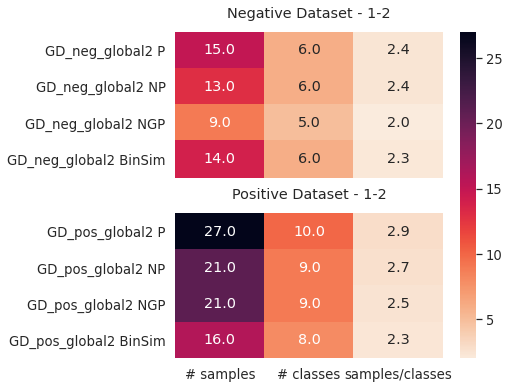

In [65]:
dist_only = df_PLSDA_stats[['# samples', '# classes', 'samples/classes']]
line = pd.DataFrame([], columns=dist_only.columns, index=[''])
display_df = pd.concat([dist_only.iloc[:4], line, dist_only.iloc[4:8]])
#display_df

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, ax = plt.subplots(figsize=(6,6))
        hm = sns.heatmap(display_df, annot=True, fmt='.1f', ax=ax, cmap = sns.cm.rocket_r)
        bottom, top = ax.get_ylim()

        plt.text(1.5,-0.5,'Negative Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
        plt.text(1.5,4.5,'Positive Dataset - 1-2',horizontalalignment='center', verticalalignment='center')
plt.show()

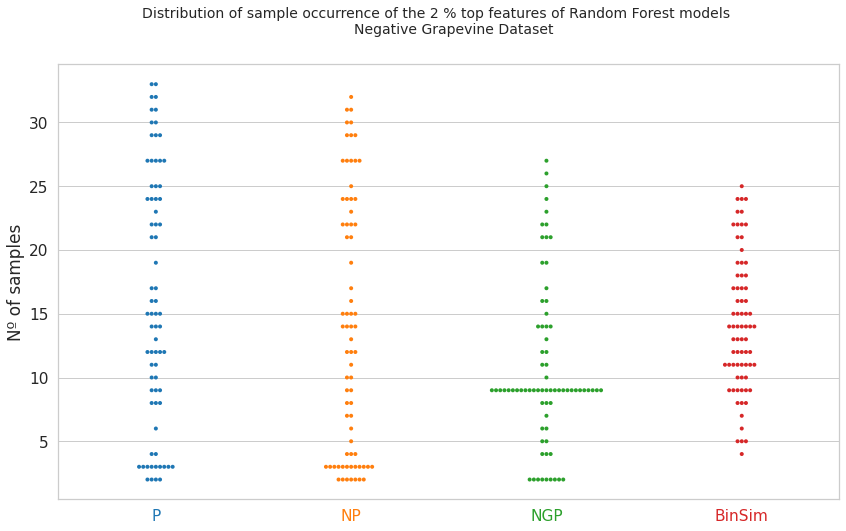

In [66]:
df_PLSDA_sample_dist = {name: PLSDA_all[name]['n samples'] for name in PLSDA_all if PLSDA_all[name]['dskey']=='GD_neg_global2'}
df_PLSDA_sample_dist = pd.DataFrame(df_PLSDA_sample_dist)
# Plot the swarm plot and adjust parameters

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_PLSDA_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Nº of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        Negative Grapevine Dataset"""

        f.suptitle(title, fontsize=14)
#plt.savefig('RF-NGD-IF')
plt.show()

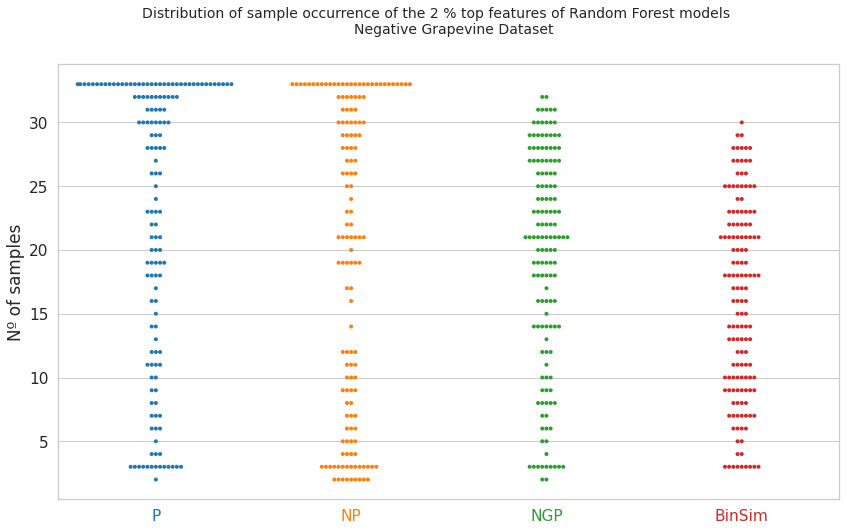

In [67]:
df_PLSDA_sample_dist = {name: PLSDA_all[name]['n samples'] for name in PLSDA_all if PLSDA_all[name]['dskey']=='GD_pos_global2'}
df_PLSDA_sample_dist = pd.DataFrame(df_PLSDA_sample_dist)
# Plot the swarm plot and adjust parameters

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_PLSDA_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Nº of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        Negative Grapevine Dataset"""

        f.suptitle(title, fontsize=14)
#plt.savefig('RF-NGD-IF')
plt.show()

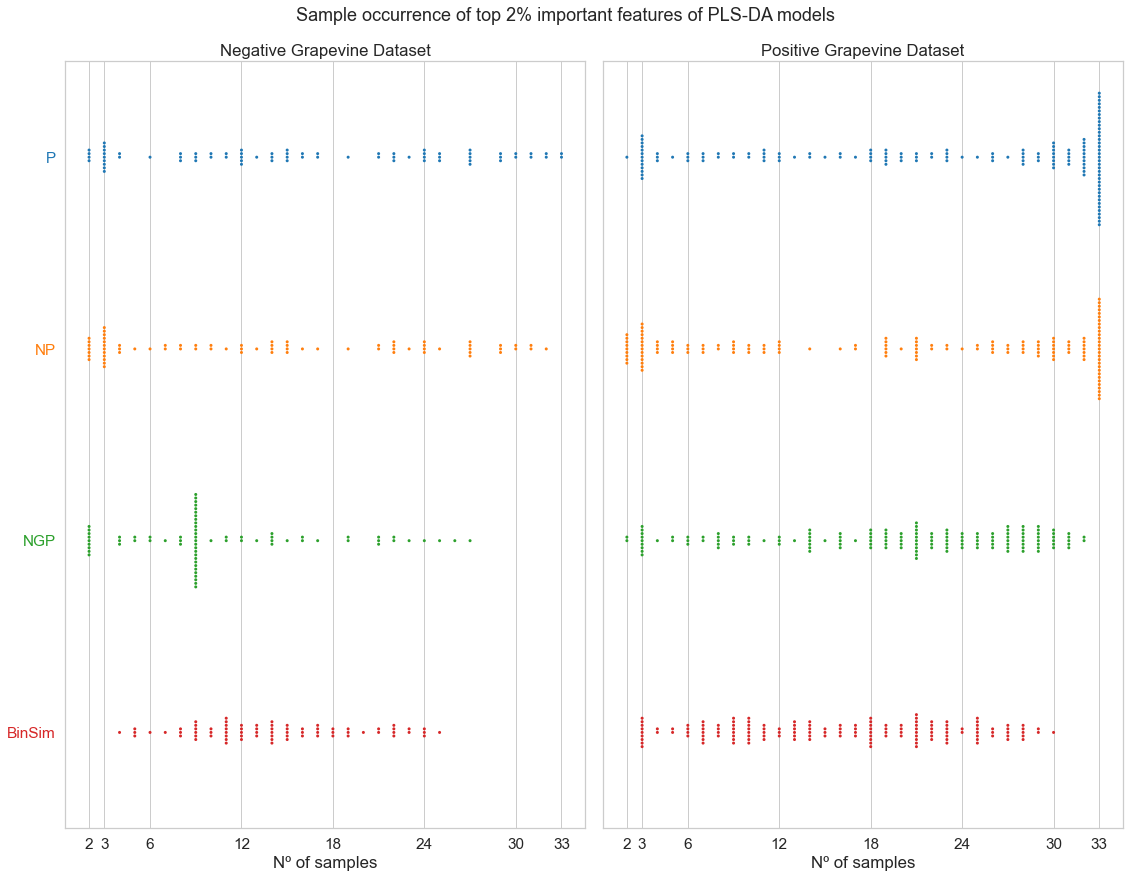

In [68]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, (axl, axr) = plt.subplots(1, 2, figsize=(16,12.5))

        colors = sns.color_palette('tab10', 4)
        tl = ticker.FixedLocator([2, 3, 6, 12, 18, 24, 30, 33])
        
        to_plot = [name for name in PLSDA_all if PLSDA_all[name]['dskey']=='GD_neg_global2']
        df_sample_dist = {PLSDA_all[name]['treatment']: PLSDA_all[name]['n samples'] for name in to_plot}
        df_sample_dist = pd.DataFrame(df_sample_dist)
        # Plot the swarm plot and adjust parameters
        sns.swarmplot(data=df_sample_dist, size=3, palette=colors, orient='h', ax=axl)
        title = "Negative Grapevine Dataset"
        axl.set(xlabel='Nº of samples', title=title)
        for ticklabel, tickcolor in zip(axl.get_yticklabels(), colors):
            ticklabel.set_color(tickcolor)
        axl.xaxis.set_major_locator(tl)
        
        to_plot = [name for name in PLSDA_all if PLSDA_all[name]['dskey']=='GD_pos_global2']
        df_sample_dist = {PLSDA_all[name]['treatment']: PLSDA_all[name]['n samples'] for name in to_plot}
        df_sample_dist = pd.DataFrame(df_sample_dist)
        
        sns.swarmplot(data=df_sample_dist, size=3, palette=colors, orient='h', ax=axr)
        title = "Positive Grapevine Dataset"
        axr.set(xlabel='Nº of samples', yticklabels = [], title=title)
        axr.xaxis.set_major_locator(tl)

        f.suptitle("Sample occurrence of top 2% important features of PLS-DA models", fontsize=18)
        plt.tight_layout()

        #plt.savefig('RF-NGD-IF')
        plt.show()

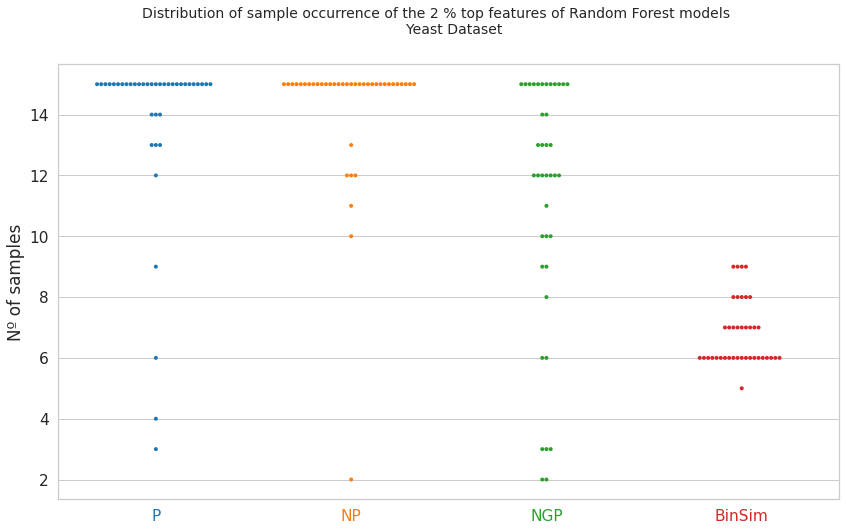

In [69]:
df_PLSDA_sample_dist = {name: PLSDA_all[name]['n samples'] for name in PLSDA_all if PLSDA_all[name]['dskey']=='YD'}
df_PLSDA_sample_dist = pd.DataFrame(df_PLSDA_sample_dist)
# Plot the swarm plot and adjust parameters

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_PLSDA_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Nº of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        Yeast Dataset"""

        f.suptitle(title, fontsize=14)
#plt.savefig('RF-NGD-IF')
plt.show()

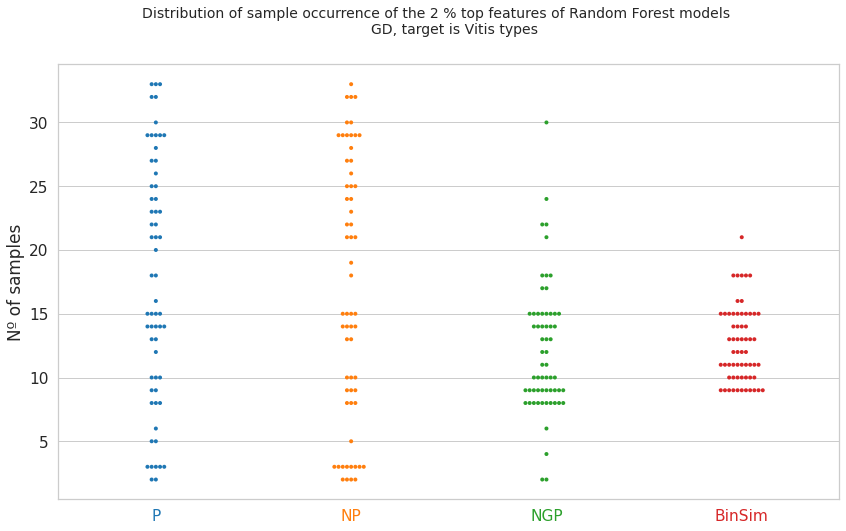

In [70]:
df_PLSDA_sample_dist = {name: PLSDA_all[name]['n samples'] for name in PLSDA_all if PLSDA_all[name]['dskey']=='vitis_types'}
df_PLSDA_sample_dist = pd.DataFrame(df_PLSDA_sample_dist)
# Plot the swarm plot and adjust parameters

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, ax = plt.subplots(figsize=(14,8))

        colors = sns.color_palette('tab10', 4)
        sns.swarmplot(data=df_PLSDA_sample_dist, size=4, palette=colors)

        ax.set(xticklabels = ['P','NP','NGP','BinSim'])
        ax.set_ylabel('Nº of samples')
        for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(tickcolor)
        title = """Distribution of sample occurrence of the 2 % top features of Random Forest models
        GD, target is Vitis types"""

        f.suptitle(title, fontsize=14)
#plt.savefig('RF-NGD-IF')
plt.show()

#### Intersections of Important Features used to build each differently-treated dataset - PLS-DA

#### Negative Grapevine Dataset - Information (after some calculations) for Fig 3.6

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram

Easier ways to obtain the results directly are available but since it is already done.

In [71]:
# Since we only want counts, let's use the list of locs for the important features
features_as_sets = {name:{} for name in datasets}
for name, plsdict in PLSDA_all.items():
    features_as_sets[plsdict['dskey']][plsdict['treatment']] = set(PLSDA_all[name]['top features'])

In [72]:
# How many Features are in at least one of the sets of important features of the differently-treated dataset
features = features_as_sets['GD_neg_global2']
union = list(itertools.accumulate(features.values(), set.union))[-1]
print('Nº of different features across the sets of important features:', len(union))

# How many Features are in all sets of important features of the differently-treated dataset
intersection = list(itertools.accumulate(features.values(), set.intersection))[-1]
print(f'Nº of features present in all sets of important features: {len(intersection)}\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4), dtype=int), index=features.keys(), columns=features.keys())
for fi in features:
    for fj in features:
        intersec.loc[fi,fj] = len(features[fi].intersection(features[fj]))   
        
# Intersections of 3 of the 4 different sets of important features
for i,j,k in itertools.combinations(features,3):
    print('Sets of features considered:',i,',',j,',',k,'.',
          'Number of features in the 3 sets:', len(set.intersection(features[i], features[j], features[k])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
intersec

Nº of different features across the sets of important features: 184
Nº of features present in all sets of important features: 8

Sets of features considered: P , NP , NGP . Number of features in the 3 sets: 19
Sets of features considered: P , NP , BinSim . Number of features in the 3 sets: 10
Sets of features considered: P , NGP , BinSim . Number of features in the 3 sets: 9
Sets of features considered: NP , NGP , BinSim . Number of features in the 3 sets: 9

Dataframe with the intersection of two set of important features for each pairwise combination:


,P,NP,NGP,BinSim
P,73,61,20,13
NP,61,73,22,11
NGP,20,22,73,20
BinSim,13,11,20,73


#### Positive Grapevine Dataset - Information (after some calculations) for Suppl. Fig. 6.8

Be careful with features present in all sets, in 3 of the sets and in 2 sets for calculating values for Venn Diagram.

Easier ways to obtain the results directly are available but since it is already done.

In [73]:
# How many Features are in at least one of the sets of important features of the differently-treated dataset
features = features_as_sets['GD_pos_global2']
union = list(itertools.accumulate(features.values(), set.union))[-1]
print('Nº of different features across the sets of important features:', len(union))

# How many Features are in all sets of important features of the differently-treated dataset
intersection = list(itertools.accumulate(features.values(), set.intersection))[-1]
print(f'Nº of features present in all sets of important features: {len(intersection)}\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4), dtype=int), index=features.keys(), columns=features.keys())
for fi in features:
    for fj in features:
        intersec.loc[fi,fj] = len(features[fi].intersection(features[fj]))   
        
# Intersections of 3 of the 4 different sets of important features
for i,j,k in itertools.combinations(features,3):
    print('Sets of features considered:',i,',',j,',',k,'.',
          'Number of features in the 3 sets:', len(set.intersection(features[i], features[j], features[k])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
intersec

Nº of different features across the sets of important features: 340
Nº of features present in all sets of important features: 16

Sets of features considered: P , NP , NGP . Number of features in the 3 sets: 34
Sets of features considered: P , NP , BinSim . Number of features in the 3 sets: 17
Sets of features considered: P , NGP , BinSim . Number of features in the 3 sets: 20
Sets of features considered: NP , NGP , BinSim . Number of features in the 3 sets: 27

Dataframe with the intersection of two set of important features for each pairwise combination:


,P,NP,NGP,BinSim
P,141,99,38,23
NP,99,141,55,28
NGP,38,55,141,63
BinSim,23,28,63,141


In [74]:
# How many Features are in at least one of the sets of important features of the differently-treated dataset
features = features_as_sets['GD_neg_class2']
union = list(itertools.accumulate(features.values(), set.union))[-1]
print('Nº of different features across the sets of important features:', len(union))

# How many Features are in all sets of important features of the differently-treated dataset
intersection = list(itertools.accumulate(features.values(), set.intersection))[-1]
print(f'Nº of features present in all sets of important features: {len(intersection)}\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4), dtype=int), index=features.keys(), columns=features.keys())
for fi in features:
    for fj in features:
        intersec.loc[fi,fj] = len(features[fi].intersection(features[fj]))   
        
# Intersections of 3 of the 4 different sets of important features
for i,j,k in itertools.combinations(features,3):
    print('Sets of features considered:',i,',',j,',',k,'.',
          'Number of features in the 3 sets:', len(set.intersection(features[i], features[j], features[k])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
intersec

Nº of different features across the sets of important features: 145
Nº of features present in all sets of important features: 6

Sets of features considered: P , NP , NGP . Number of features in the 3 sets: 18
Sets of features considered: P , NP , BinSim . Number of features in the 3 sets: 9
Sets of features considered: P , NGP , BinSim . Number of features in the 3 sets: 6
Sets of features considered: NP , NGP , BinSim . Number of features in the 3 sets: 6

Dataframe with the intersection of two set of important features for each pairwise combination:


,P,NP,NGP,BinSim
P,61,51,18,10
NP,51,61,20,9
NGP,18,20,61,24
BinSim,10,9,24,61


In [75]:
# How many Features are in at least one of the sets of important features of the differently-treated dataset
features = features_as_sets['GD_pos_class2']
union = list(itertools.accumulate(features.values(), set.union))[-1]
print('Nº of different features across the sets of important features:', len(union))

# How many Features are in all sets of important features of the differently-treated dataset
intersection = list(itertools.accumulate(features.values(), set.intersection))[-1]
print(f'Nº of features present in all sets of important features: {len(intersection)}\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4), dtype=int), index=features.keys(), columns=features.keys())
for fi in features:
    for fj in features:
        intersec.loc[fi,fj] = len(features[fi].intersection(features[fj]))   
        
# Intersections of 3 of the 4 different sets of important features
for i,j,k in itertools.combinations(features,3):
    print('Sets of features considered:',i,',',j,',',k,'.',
          'Number of features in the 3 sets:', len(set.intersection(features[i], features[j], features[k])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
intersec

Nº of different features across the sets of important features: 232
Nº of features present in all sets of important features: 5

Sets of features considered: P , NP , NGP . Number of features in the 3 sets: 18
Sets of features considered: P , NP , BinSim . Number of features in the 3 sets: 6
Sets of features considered: P , NGP , BinSim . Number of features in the 3 sets: 7
Sets of features considered: NP , NGP , BinSim . Number of features in the 3 sets: 13

Dataframe with the intersection of two set of important features for each pairwise combination:


,P,NP,NGP,BinSim
P,91,61,20,8
NP,61,91,33,14
NGP,20,33,91,35
BinSim,8,14,35,91


In [76]:
# How many Features are in at least one of the sets of important features of the differently-treated dataset
features = features_as_sets['vitis_types']
union = list(itertools.accumulate(features.values(), set.union))[-1]
print('Nº of different features across the sets of important features:', len(union))

# How many Features are in all sets of important features of the differently-treated dataset
intersection = list(itertools.accumulate(features.values(), set.intersection))[-1]
print(f'Nº of features present in all sets of important features: {len(intersection)}\n')

# Build DataFrame for pairwise intersection of the sets of important features
intersec = pd.DataFrame(np.zeros((4,4), dtype=int), index=features.keys(), columns=features.keys())
for fi in features:
    for fj in features:
        intersec.loc[fi,fj] = len(features[fi].intersection(features[fj]))   
        
# Intersections of 3 of the 4 different sets of important features
for i,j,k in itertools.combinations(features,3):
    print('Sets of features considered:',i,',',j,',',k,'.',
          'Number of features in the 3 sets:', len(set.intersection(features[i], features[j], features[k])))

print('\nDataframe with the intersection of two set of important features for each pairwise combination:')    
intersec

Nº of different features across the sets of important features: 142
Nº of features present in all sets of important features: 10

Sets of features considered: P , NP , NGP . Number of features in the 3 sets: 15
Sets of features considered: P , NP , BinSim . Number of features in the 3 sets: 10
Sets of features considered: P , NGP , BinSim . Number of features in the 3 sets: 12
Sets of features considered: NP , NGP , BinSim . Number of features in the 3 sets: 10

Dataframe with the intersection of two set of important features for each pairwise combination:


,P,NP,NGP,BinSim
P,61,48,18,12
NP,48,61,17,10
NGP,18,17,61,34
BinSim,12,10,34,61


### Example of models built with the full dataset and sample representation on the two most important Components/Latent Variables

#### NGP and BinSim pre-treated Negative GD - Alignment: 1-2

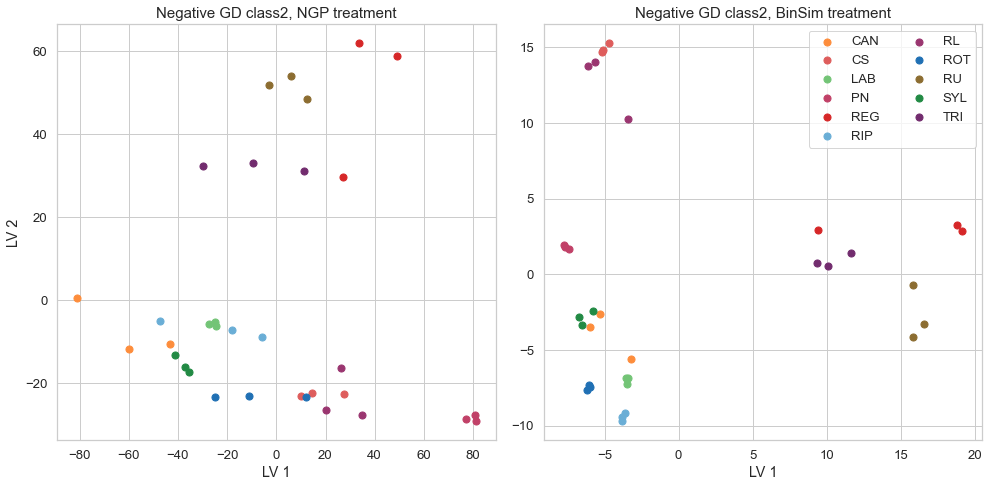

In [78]:
n_components = 11

model, scores = ma.fit_PLSDA_model(datasets['GD_neg_class2']['NGP'],
                                   datasets['GD_neg_class2']['target'], n_comp=n_components)
model2, scores2 = ma.fit_PLSDA_model(datasets['GD_neg_class2']['BinSim'],
                                     datasets['GD_neg_class2']['target'], n_comp=n_components)

lcolors = datasets['GD_neg_class2']['label_colors']

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        plot_PCA(scores, lcolors, title="Negative GD class2, NGP treatment", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        plot_PCA(scores2, lcolors, title="Negative GD class2, BinSim treatment", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=2)               
        plt.tight_layout()
        plt.show()

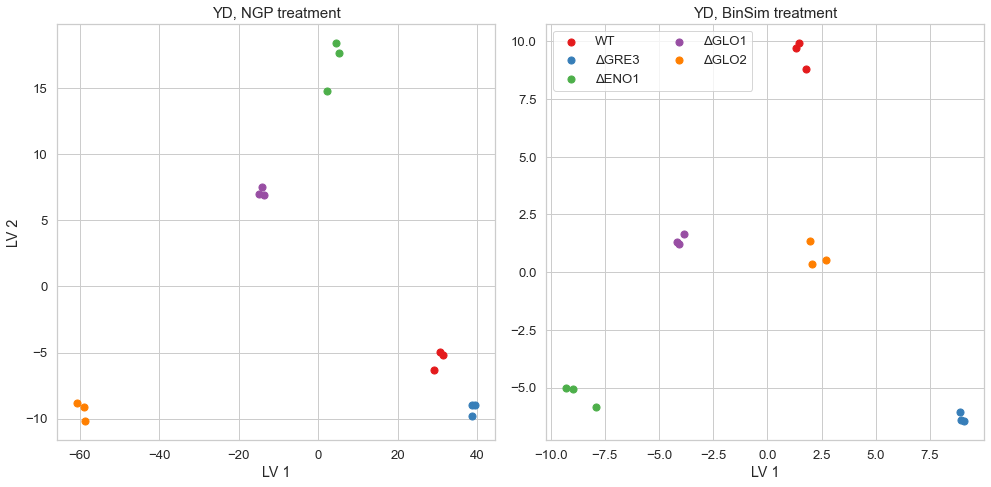

In [79]:
n_components = 11

model, scores = ma.fit_PLSDA_model(datasets['YD']['NGP'],
                                   datasets['YD']['target'], n_comp=n_components)
model2, scores2 = ma.fit_PLSDA_model(datasets['YD']['BinSim'],
                                     datasets['YD']['target'], n_comp=n_components)

lcolors = datasets['YD']['label_colors']

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        plot_PCA(scores, lcolors, title="YD, NGP treatment", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        plot_PCA(scores2, lcolors, title="YD, BinSim treatment", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper left', ncol=2)               
        plt.tight_layout()
        plt.show()

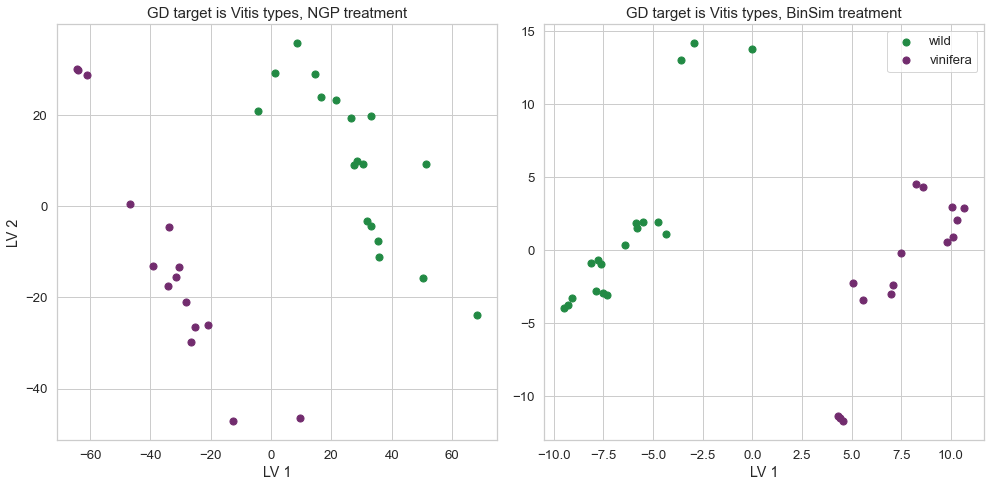

In [80]:
n_components = 11

model, scores = ma.fit_PLSDA_model(datasets['vitis_types']['NGP'],
                                   datasets['vitis_types']['target'], n_comp=n_components)
model2, scores2 = ma.fit_PLSDA_model(datasets['vitis_types']['BinSim'],
                                     datasets['vitis_types']['target'], n_comp=n_components)

lcolors = datasets['vitis_types']['label_colors']

with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        fig, (axl, axr) = plt.subplots(1,2, figsize=(14,7))
        plot_PCA(scores, lcolors, title="GD target is Vitis types, NGP treatment", ax=axl)
        #plt.legend(loc='upper left', ncol=2)

        plot_PCA(scores2, lcolors, title="GD target is Vitis types, BinSim treatment", ax=axr)
        axr.set_ylabel('')
        axr.legend(loc='upper right', ncol=1)               
        plt.tight_layout()
        plt.show()